In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
# get_ipython().magic(u'matplotlib auto')
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# import torch
from tensorflow import keras
import statistics

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation
from tensorflow import reshape
from keras.utils import np_utils
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D,AveragePooling1D
from tensorflow.keras.layers import SeparableConv1D, Bidirectional
from tensorflow.keras.layers import LocallyConnected2D
from tensorflow.keras.layers import ZeroPadding2D,ZeroPadding1D, MaxPooling2D, Bidirectional
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import CSVLogger,LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [3]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import std
# import coremltools
# from torch import nn, optim
# import torch.nn.functional as F
import scipy.io
from scipy import stats
#from IPython.display import display, HTML
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import TimeDistributed
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

In [41]:
# The number of steps within one time segment
TIME_PERIODS = 5000
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 5000
N_FEATURES = 12

In [42]:
column_names = ['C'+str(j) for j in range(1, N_FEATURES+1)]
lst = ['Class_label']
column_names = column_names+lst
print(column_names)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'Class_label']


In [43]:
def read_data_Train(file_path_Train):
    df_Train = pd.read_csv(file_path_Train,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Train['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Train['Class_label'] = df_Train['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Train.dropna(axis=0, how='any', inplace=True)
    return df_Train
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [44]:
def show_basic_dataframe_info(dataframe):
    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [45]:
def read_data_Test(file_path_Test):
    df_Test = pd.read_csv(file_path_Test,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Test['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Test['Class_label'] = df_Test['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Test.dropna(axis=0, how='any', inplace=True)
    return df_Test

In [46]:
 pd.options.display.float_format = "{:,.5f}".format

In [47]:
# 15 function to segment data into trial lengths (trial length =513 samples in this dataset)
def create_segments_and_labels(df, time_steps,step,n_features, label_name):
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
      for j in range(1, n_features+1):
        L = ('C'+str(j)) 
        segments.append(df[str(L)].values[i: i + time_steps])
      label = stats.mode(df[label_name][i: i + time_steps])[0][0]
      labels.append(label)
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, n_features)
    labels = np.asarray(labels)
    return reshaped_segments, labels

In [48]:
verbose, epochs, batch_size = 0, 120, 32

In [49]:
# def step_decay(epoch):
#    initial_lrate = 0.1
#    drop = 0.1
#    epochs_drop = 16.0
#    lrate = initial_lrate * tf.math.pow(drop,  
#            tf.math.floor((1+epoch)/epochs_drop))
#    return lrate

In [59]:
def step_decay(epoch):
   initial_lrate = 1e-3
   drop = 0.1
   epochs_drop = 40.0
   lrate = initial_lrate * tf.math.pow(drop,  
           tf.math.floor((1+epoch)/epochs_drop))
   return lrate

In [60]:
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [61]:
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
test_acc=[]

In [62]:
# import os
# path='/media/naveen/nav/mat_codes/nina_DB2_codes/prep_nbov_olsson/sub_wise_process_TT/'
path='/media/naveen/nav/mat_codes/nina_DB2_codes/prep_nb_D2_HT_olsson/sub_wise_process_TT/'


In [63]:
for i in range(1,41):
    file_path_train=path+'S'+str(i)+'_'+'tr'+'.'+'csv'
    print(file_path_train)
    df_Train=read_data_Train(file_path_train)
    show_basic_dataframe_info(df_Train)
    df_Train.head(5)
    file_path_test=path+'S'+str(i)+'_'+'tt'+'.'+'csv'
    print(file_path_test)
    df_Test=read_data_Test(file_path_test)
    show_basic_dataframe_info(df_Test)
    df_Test.head(5)
    
    scaler = preprocessing.StandardScaler().fit(df_Train.iloc[:,0:N_FEATURES])
    df_Train.iloc[:,0:N_FEATURES]=scaler.transform(df_Train.iloc[:,0:N_FEATURES])
    df_Test.iloc[:,0:N_FEATURES]=scaler.transform(df_Test.iloc[:,0:N_FEATURES])
       
    LABEL = 'ActivityEncoded'
    # Transform the labels from String to Integer via LabelEncoder
    le = preprocessing.LabelEncoder()
    # Add a new column to the existing DataFrame with the encoded values
    df_Train[LABEL] = le.fit_transform(df_Train['Class_label'].values.ravel())
    # df_Valid[LABEL] = le.fit_transform(df_Valid['Class_label'].values.ravel())
    df_Test[LABEL] = le.fit_transform(df_Test['Class_label'].values.ravel())
    x_train, y_train = create_segments_and_labels(df_Train,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
    print('x_train shape: ', x_train.shape)
    # print(x_train)
    print(x_train.shape[0], 'training samples')
    print('y_train shape: ', y_train.shape)
    # Set input & output dimensions
    num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
    print('num_time_periods',num_time_periods)
    print('num_sensors',num_sensors)
    num_classes = le.classes_.size
    print('class_list',list(le.classes_))
    # input_shape = (num_time_periods,num_sensors)
    # print(input_shape)
    input_shape = (num_time_periods,num_sensors)
    #x_train = x_train.reshape(x_train.shape[0], input_shape)
    print('x_train shape:', x_train[0].shape)
    print('input_shape:', input_shape)
    x_train = x_train.astype('float32')
    # x_train = [torch.tensor(arr, dtype=torch.float32) for arr in x_train]
    # y_train = y_train.astype('float32')
    print('y_train shape',y_train.shape)
    y_train_hot = np_utils.to_categorical(y_train, num_classes)
#     print(y_train_hot)
    # y_train_hot= [torch.tensor(arr, dtype=torch.uint8) for arr in y_train_hot]
    print('New y_train shape: ', y_train_hot.shape)
    x_test, y_test = create_segments_and_labels(df_Test,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
    print('x_test shape: ', x_test.shape)
    # print(x_train)
    print(x_test.shape[0], 'testing samples')
    print('y_test shape: ', y_test.shape)
    # Set input_shape / reshape for Keras
    #x_test = x_test.reshape(x_test.shape[0], input_shape)
    x_test = x_test.astype('float32')
    y_test = y_test.astype('float32')
    y_test_hot = np_utils.to_categorical(y_test, num_classes)
    # n_steps, n_length = 20, 25
    # n_steps, n_length= 10, 50
    # n_steps, n_length= 16, 32
    n_steps, n_length = 50, 100
    n_depth=12
    x_train = x_train.reshape(x_train.shape[0], n_steps, n_length,n_depth)
    print('x_train shape: ', x_train.shape)
    # x_valid = x_valid.reshape(x_valid.shape[0], n_steps, n_length, n_depth)
    # print('x_valid shape: ', x_valid.shape)
    x_test = x_test.reshape(x_test.shape[0], n_steps, n_length,n_depth)
    print('x_test shape: ', x_test.shape)
    n_outputs = y_train_hot.shape[1]
    print('n_outputs',n_outputs)
#     model = Sequential()
#     model.add(Conv2D(filters=64, kernel_size=(9,1), padding='same',kernel_regularizer=l2(1e-04), kernel_initializer="he_normal",strides=(3,1), \
#                            input_shape=(n_steps,n_length,n_depth)))
#     model.add(MaxPooling2D(pool_size=(8,1),strides=(2,1)))
#     model.add(Activation('tanh'))
#     model.add(Conv2D(filters=64, kernel_size=(5,1),padding="same",kernel_regularizer=l2(1e-04),kernel_initializer="he_normal",strides=(2,1)))
#     model.add(Activation('tanh'))
#     model.add(Dropout(0.2093))
#     model.add(Activation('relu'))
#     model.add(Flatten())
#     model.add(Dense(512, activation='tanh'))
#     model.add(Dense(n_outputs, activation='softmax'))
#     adam=optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999,epsilon=1e-08, amsgrad=False)
#     sgd=optimizers.SGD(learning_rate=2.17e-3, momentum=0.9, nesterov=False, name='SGD')
#  conv2d implementation
#     model = Sequential()
#     model.add(Conv2D(filters=64, kernel_size=(9,1), padding='same', kernel_initializer="he_normal",strides=(3,1),kernel_regularizer=l1(1e-04), \
#                            input_shape=(n_steps,n_length,n_depth)))
#     model.add(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None))
#     model.add(MaxPooling2D(pool_size=(4,1),strides=(2,1)))
#     model.add(Activation('tanh'))
#     model.add(Conv2D(filters=64, kernel_size=(5,1),padding="same",kernel_initializer="he_normal",strides=(2,1),kernel_regularizer=l1(1e-04)))
#     model.add(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None))
#     model.add(Activation('tanh'))
#     model.add(Dropout(0.2093))
#     model.add(Activation('relu'))
#     model.add(Flatten())
#     model.add(Dense(512, activation='tanh',kernel_initializer="he_normal"))
#     model.add(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None))
#     model.add(Activation('tanh'))
#     model.add(Dense(n_outputs, activation='softmax',kernel_initializer="he_normal"))
# conv1d implementation
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=9, padding='same', kernel_initializer="he_normal",strides=3,kernel_regularizer=l1(1e-04)), \
                               input_shape=(n_steps,n_length,n_depth)))
    model.add(BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None))
    model.add(TimeDistributed(MaxPooling1D(pool_size=4,strides=2)))
    model.add(TimeDistributed(Activation('tanh')))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=5,padding="same",kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04))))
    model.add(BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None))
    model.add(TimeDistributed(Activation('tanh')))
    model.add(TimeDistributed(Dropout(0.2093)))
    model.add(TimeDistributed(Activation('relu')))
    model.add(Flatten())
    model.add(Dense(512, activation='tanh'))
    model.add(BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None))
    model.add(Dense(n_outputs, activation='softmax'))
    adam=optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999,epsilon=1e-08, amsgrad=False)
    checkpoint_filepath = '/media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5'
    # model.load_weights(checkpoint_filepath) 
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,verbose=1, monitor='val_accuracy',save_weights_only=True,save_best_only=True)
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
#     tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/olsson/CNN20X10/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)
    csv_logger = CSVLogger('/media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/LSTM_nina_20X100.csv', append=True, separator=';')
    history = model.fit(x_train, y_train_hot, epochs=epochs, batch_size=batch_size, callbacks=[csv_logger,checkpoint_callback,lrate],validation_data=(x_test, y_test_hot), verbose=1)
    best_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
    print('epoch_number',best_index+1)
    print('train accuracy and validation accuracy', history.history['accuracy'][best_index], history.history['val_accuracy'][best_index])
    model.load_weights(checkpoint_filepath) 
    _, testaccuracy = model.evaluate(x_test, y_test_hot, batch_size=batch_size, verbose=1)
    print('test_accuracy',testaccuracy)
    test_acc.append(testaccuracy)
    print(test_acc)
    print('test_mean for %d subjects:',i)
#     print(test_acc)
    test_mean=statistics.mean(test_acc)
    print(test_mean)

/media/naveen/nav/mat_codes/nina_DB2_codes/prep_nb_D2_HT_olsson/sub_wise_process_TT/S1_tr.csv
Number of columns in the dataframe: 13
Number of rows in the dataframe: 980000

/media/naveen/nav/mat_codes/nina_DB2_codes/prep_nb_D2_HT_olsson/sub_wise_process_TT/S1_tt.csv
Number of columns in the dataframe: 13
Number of rows in the dataframe: 490000

x_train shape:  (195, 5000, 12)
195 training samples
y_train shape:  (195,)
num_time_periods 5000
num_sensors 12
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0]
x_train shape: (5000, 12)
input_shape: (5000, 12)
y_train shape (195,)
New y_train shape:  (195, 49)
x_test shape:  (97, 5000, 12)
97 testing samples
y_test shape:  (97,)
x_train shape:  (195, 50, 100, 12)
x_test shape:  (97, 50, 100, 12)
n_o

5/7 [====================>.........] - ETA: 0s - loss: 0.2314 - accuracy: 1.0000
Epoch 00017: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 19ms/step - loss: 0.2394 - accuracy: 1.0000 - val_loss: 1.7491 - val_accuracy: 0.6804 - lr: 0.0010
Epoch 18/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2398 - accuracy: 1.0000
Epoch 00018: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 17ms/step - loss: 0.2418 - accuracy: 1.0000 - val_loss: 1.7779 - val_accuracy: 0.6186 - lr: 0.0010
Epoch 19/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2318 - accuracy: 1.0000
Epoch 00019: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 18ms/step - loss: 0.2562 - accuracy: 0.9949 - val_loss: 1.5009 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 20/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2388 - accuracy: 1.0000
Epoch 00020: val_accuracy did not improve from 0.

6/7 [========================>.....] - ETA: 0s - loss: 0.2123 - accuracy: 1.0000
Epoch 00045: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 16ms/step - loss: 0.2131 - accuracy: 1.0000 - val_loss: 1.4993 - val_accuracy: 0.7113 - lr: 1.0000e-04
Epoch 46/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2103 - accuracy: 1.0000
Epoch 00046: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 18ms/step - loss: 0.2187 - accuracy: 1.0000 - val_loss: 1.4460 - val_accuracy: 0.7216 - lr: 1.0000e-04
Epoch 47/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2099 - accuracy: 1.0000
Epoch 00047: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 17ms/step - loss: 0.2110 - accuracy: 1.0000 - val_loss: 1.3870 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 48/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2089 - accuracy: 1.0000
Epoch 00048: val_accuracy did not imp

6/7 [========================>.....] - ETA: 0s - loss: 0.2045 - accuracy: 1.0000
Epoch 00072: val_accuracy improved from 0.84536 to 0.85567, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 43ms/step - loss: 0.2051 - accuracy: 1.0000 - val_loss: 1.2505 - val_accuracy: 0.8557 - lr: 1.0000e-04
Epoch 73/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2043 - accuracy: 1.0000
Epoch 00073: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 17ms/step - loss: 0.2044 - accuracy: 1.0000 - val_loss: 1.2550 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 74/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2044 - accuracy: 1.0000
Epoch 00074: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 18ms/step - loss: 0.2047 - accuracy: 1.0000 - val_loss: 1.2598 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 75/120
6/7 [============

Epoch 100/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2036 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 17ms/step - loss: 0.2037 - accuracy: 1.0000 - val_loss: 1.1967 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 101/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2035 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 18ms/step - loss: 0.2036 - accuracy: 1.0000 - val_loss: 1.2125 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 102/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2038 - accuracy: 1.0000
Epoch 00102: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 18ms/step - loss: 0.2046 - accuracy: 1.0000 - val_loss: 1.1985 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 103/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2035 - accuracy: 1.0000
Epoch 00103: val_acc

6/7 [========================>.....] - ETA: 0s - loss: 4.4964 - accuracy: 0.2292
Epoch 00001: val_accuracy improved from -inf to 0.25773, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 48ms/step - loss: 4.4665 - accuracy: 0.2308 - val_loss: 3.0638 - val_accuracy: 0.2577 - lr: 0.0010
Epoch 2/120
6/7 [========================>.....] - ETA: 0s - loss: 0.6713 - accuracy: 0.9583
Epoch 00002: val_accuracy improved from 0.25773 to 0.52577, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 1s 78ms/step - loss: 0.6717 - accuracy: 0.9590 - val_loss: 2.0745 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 3/120
5/7 [====================>.........] - ETA: 0s - loss: 0.3848 - accuracy: 0.9937
Epoch 00003: val_accuracy improved from 0.52577 to 0.68041, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/ch

Epoch 28/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2047 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 18ms/step - loss: 0.2050 - accuracy: 1.0000 - val_loss: 1.4499 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 29/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2042 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 17ms/step - loss: 0.2044 - accuracy: 1.0000 - val_loss: 1.5110 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 30/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2038 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 17ms/step - loss: 0.2041 - accuracy: 1.0000 - val_loss: 1.5017 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 31/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2032 - accuracy: 1.0000
Epoch 00031: val_accuracy did not im

6/7 [========================>.....] - ETA: 0s - loss: 0.1983 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 17ms/step - loss: 0.1985 - accuracy: 1.0000 - val_loss: 1.4196 - val_accuracy: 0.7010 - lr: 1.0000e-04
Epoch 57/120
5/7 [====================>.........] - ETA: 0s - loss: 0.1981 - accuracy: 1.00 - ETA: 0s - loss: 0.1982 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 19ms/step - loss: 0.1983 - accuracy: 1.0000 - val_loss: 1.4333 - val_accuracy: 0.7010 - lr: 1.0000e-04
Epoch 58/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1982 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 17ms/step - loss: 0.1982 - accuracy: 1.0000 - val_loss: 1.4357 - val_accuracy: 0.7010 - lr: 1.0000e-04
Epoch 59/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1981 - accuracy: 1.

Epoch 84/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1967 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 18ms/step - loss: 0.1967 - accuracy: 1.0000 - val_loss: 1.3421 - val_accuracy: 0.7113 - lr: 1.0000e-05
Epoch 85/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1967 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 17ms/step - loss: 0.1969 - accuracy: 1.0000 - val_loss: 1.3407 - val_accuracy: 0.7010 - lr: 1.0000e-05
Epoch 86/120
5/7 [====================>.........] - ETA: 0s - loss: 0.1966 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 19ms/step - loss: 0.1967 - accuracy: 1.0000 - val_loss: 1.3412 - val_accuracy: 0.7113 - lr: 1.0000e-05
Epoch 87/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1967 - accuracy: 1.0000
Epoch 00087: val_accurac

Epoch 112/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1965 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 19ms/step - loss: 0.1966 - accuracy: 1.0000 - val_loss: 1.3091 - val_accuracy: 0.7010 - lr: 1.0000e-05
Epoch 113/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1964 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 17ms/step - loss: 0.1966 - accuracy: 1.0000 - val_loss: 1.3128 - val_accuracy: 0.7010 - lr: 1.0000e-05
Epoch 114/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1965 - accuracy: 1.0000
Epoch 00114: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 17ms/step - loss: 0.1966 - accuracy: 1.0000 - val_loss: 1.3138 - val_accuracy: 0.7010 - lr: 1.0000e-05
Epoch 115/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1965 - accuracy: 1.0000
Epoch 00115: val_acc

7/7 [==============================] - 0s 64ms/step - loss: 0.2338 - accuracy: 1.0000 - val_loss: 1.4707 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 7/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2294 - accuracy: 1.0000
Epoch 00007: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 17ms/step - loss: 0.2305 - accuracy: 1.0000 - val_loss: 1.5643 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 8/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2294 - accuracy: 1.0000
Epoch 00008: val_accuracy improved from 0.70103 to 0.71134, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 43ms/step - loss: 0.2382 - accuracy: 1.0000 - val_loss: 1.5291 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 9/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2262 - accuracy: 1.0000
Epoch 00009: val_accuracy improved from 0.71134 to 0.75258, saving model to /media/nave

6/7 [========================>.....] - ETA: 0s - loss: 0.2091 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2096 - accuracy: 1.0000 - val_loss: 1.5576 - val_accuracy: 0.6804 - lr: 0.0010
Epoch 34/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2084 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2089 - accuracy: 1.0000 - val_loss: 1.5460 - val_accuracy: 0.6495 - lr: 0.0010
Epoch 35/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2076 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2079 - accuracy: 1.0000 - val_loss: 1.4669 - val_accuracy: 0.6701 - lr: 0.0010
Epoch 36/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2072 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.

6/7 [========================>.....] - ETA: 0s - loss: 0.2039 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2041 - accuracy: 1.0000 - val_loss: 1.3304 - val_accuracy: 0.7216 - lr: 1.0000e-04
Epoch 62/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2040 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2044 - accuracy: 1.0000 - val_loss: 1.3295 - val_accuracy: 0.7010 - lr: 1.0000e-04
Epoch 63/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2038 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 18ms/step - loss: 0.2041 - accuracy: 1.0000 - val_loss: 1.2986 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 64/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2038 - accuracy: 1.0000
Epoch 00064: val_accuracy did not imp

Epoch 89/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2029 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2032 - accuracy: 1.0000 - val_loss: 1.3249 - val_accuracy: 0.7216 - lr: 1.0000e-05
Epoch 90/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2028 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2029 - accuracy: 1.0000 - val_loss: 1.3078 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 91/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2029 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2029 - accuracy: 1.0000 - val_loss: 1.3207 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 92/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2029 - accuracy: 1.0000
Epoch 00092: val_accurac

Epoch 117/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2027 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2028 - accuracy: 1.0000 - val_loss: 1.3022 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 118/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2027 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2027 - accuracy: 1.0000 - val_loss: 1.3058 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 119/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2027 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2031 - accuracy: 1.0000 - val_loss: 1.3004 - val_accuracy: 0.7526 - lr: 1.0000e-05
Epoch 120/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2026 - accuracy: 1.0000
Epoch 00120: val_acc

7/7 [==============================] - 0s 63ms/step - loss: 0.2180 - accuracy: 1.0000 - val_loss: 1.4655 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 12/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2162 - accuracy: 1.0000
Epoch 00012: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 17ms/step - loss: 0.2164 - accuracy: 1.0000 - val_loss: 1.4091 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 13/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2150 - accuracy: 1.0000
Epoch 00013: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 17ms/step - loss: 0.2167 - accuracy: 1.0000 - val_loss: 1.4230 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 14/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2146 - accuracy: 1.0000
Epoch 00014: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 17ms/step - loss: 0.2166 - accuracy: 1.0000 - val_loss: 1.6112 - val_accuracy: 0.6907 - 

Epoch 40/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2078 - accuracy: 1.0000
Epoch 00040: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 18ms/step - loss: 0.2082 - accuracy: 1.0000 - val_loss: 2.1326 - val_accuracy: 0.5361 - lr: 1.0000e-04
Epoch 41/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2087 - accuracy: 1.0000
Epoch 00041: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 17ms/step - loss: 0.2102 - accuracy: 1.0000 - val_loss: 2.1321 - val_accuracy: 0.5567 - lr: 1.0000e-04
Epoch 42/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2084 - accuracy: 1.0000
Epoch 00042: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 18ms/step - loss: 0.2087 - accuracy: 1.0000 - val_loss: 2.1704 - val_accuracy: 0.5567 - lr: 1.0000e-04
Epoch 43/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2077 - accuracy: 1.0000
Epoch 00043: val_accurac

Epoch 68/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2036 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 18ms/step - loss: 0.2040 - accuracy: 1.0000 - val_loss: 2.0111 - val_accuracy: 0.5773 - lr: 1.0000e-04
Epoch 69/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2039 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 18ms/step - loss: 0.2041 - accuracy: 1.0000 - val_loss: 1.9995 - val_accuracy: 0.5979 - lr: 1.0000e-04
Epoch 70/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2034 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 16ms/step - loss: 0.2040 - accuracy: 1.0000 - val_loss: 1.9960 - val_accuracy: 0.5979 - lr: 1.0000e-04
Epoch 71/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2036 - accuracy: 1.0000
Epoch 00071: val_accurac

Epoch 96/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2025 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 18ms/step - loss: 0.2026 - accuracy: 1.0000 - val_loss: 1.8893 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 97/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2026 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 17ms/step - loss: 0.2026 - accuracy: 1.0000 - val_loss: 1.8984 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 98/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2024 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 18ms/step - loss: 0.2025 - accuracy: 1.0000 - val_loss: 1.8936 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 99/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2024 - accuracy: 1.0000
Epoch 00099: val_accurac

Epoch 1/120
5/7 [====================>.........] - ETA: 0s - loss: 3.9596 - accuracy: 0.2375
Epoch 00001: val_accuracy improved from -inf to 0.32990, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 51ms/step - loss: 3.7115 - accuracy: 0.2667 - val_loss: 2.8442 - val_accuracy: 0.3299 - lr: 0.0010
Epoch 2/120
6/7 [========================>.....] - ETA: 0s - loss: 0.4272 - accuracy: 0.9792
Epoch 00002: val_accuracy improved from 0.32990 to 0.65979, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 61ms/step - loss: 0.4245 - accuracy: 0.9795 - val_loss: 1.7318 - val_accuracy: 0.6598 - lr: 0.0010
Epoch 3/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2776 - accuracy: 0.9948
Epoch 00003: val_accuracy improved from 0.65979 to 0.76289, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/

6/7 [========================>.....] - ETA: 0s - loss: 0.2084 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 19ms/step - loss: 0.2086 - accuracy: 1.0000 - val_loss: 1.7229 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 28/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2080 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 18ms/step - loss: 0.2083 - accuracy: 1.0000 - val_loss: 1.6649 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 29/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2067 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2068 - accuracy: 1.0000 - val_loss: 1.5713 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 30/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2057 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.

6/7 [========================>.....] - ETA: 0s - loss: 0.2007 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 20ms/step - loss: 0.2069 - accuracy: 0.9949 - val_loss: 1.4625 - val_accuracy: 0.6907 - lr: 1.0000e-04
Epoch 56/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.87629
7/7 [==============================] - 1s 91ms/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 1.4418 - val_accuracy: 0.7010 - lr: 1.0000e-04
Epoch 57/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2006 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2008 - accuracy: 1.0000 - val_loss: 1.4367 - val_accuracy: 0.6907 - lr: 1.0000e-04
Epoch 58/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2008 - accuracy: 1.0000
Epoch 00058: val_accuracy did not imp

Epoch 83/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1995 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 18ms/step - loss: 0.1997 - accuracy: 1.0000 - val_loss: 1.3624 - val_accuracy: 0.7216 - lr: 1.0000e-05
Epoch 84/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1995 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 21ms/step - loss: 0.1998 - accuracy: 1.0000 - val_loss: 1.3505 - val_accuracy: 0.7526 - lr: 1.0000e-05
Epoch 85/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1995 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 18ms/step - loss: 0.1996 - accuracy: 1.0000 - val_loss: 1.3585 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 86/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1997 - accuracy: 1.0000
Epoch 00086: val_accurac

Epoch 111/120
5/7 [====================>.........] - ETA: 0s - loss: 0.1993 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 18ms/step - loss: 0.1994 - accuracy: 1.0000 - val_loss: 1.3267 - val_accuracy: 0.7629 - lr: 1.0000e-05
Epoch 112/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1994 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 18ms/step - loss: 0.1999 - accuracy: 1.0000 - val_loss: 1.3483 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 113/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1992 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2005 - accuracy: 1.0000 - val_loss: 1.3512 - val_accuracy: 0.7216 - lr: 1.0000e-05
Epoch 114/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1993 - accuracy: 1.0000
Epoch 00114: val_acc

Epoch 7/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2272 - accuracy: 1.0000
Epoch 00007: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 19ms/step - loss: 0.2308 - accuracy: 1.0000 - val_loss: 1.4136 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 8/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2222 - accuracy: 1.0000
Epoch 00008: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 20ms/step - loss: 0.2260 - accuracy: 1.0000 - val_loss: 1.4487 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 9/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2243 - accuracy: 1.0000
Epoch 00009: val_accuracy did not improve from 0.73196
7/7 [==============================] - 0s 17ms/step - loss: 0.2264 - accuracy: 1.0000 - val_loss: 1.5015 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 10/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2226 - accuracy: 1.0000
Epoch 00010: val_accuracy did not impro

Epoch 35/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2084 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 21ms/step - loss: 0.2091 - accuracy: 1.0000 - val_loss: 1.6542 - val_accuracy: 0.6495 - lr: 0.0010
Epoch 36/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2092 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 17ms/step - loss: 0.2099 - accuracy: 1.0000 - val_loss: 1.6410 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 37/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2089 - accuracy: 1.0000
Epoch 00037: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 17ms/step - loss: 0.2094 - accuracy: 1.0000 - val_loss: 1.5757 - val_accuracy: 0.6701 - lr: 0.0010
Epoch 38/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2083 - accuracy: 1.0000
Epoch 00038: val_accuracy did not im

Epoch 63/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2049 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 17ms/step - loss: 0.2058 - accuracy: 1.0000 - val_loss: 1.4257 - val_accuracy: 0.7010 - lr: 1.0000e-04
Epoch 64/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2050 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 17ms/step - loss: 0.2122 - accuracy: 1.0000 - val_loss: 1.4254 - val_accuracy: 0.7010 - lr: 1.0000e-04
Epoch 65/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2049 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 18ms/step - loss: 0.2051 - accuracy: 1.0000 - val_loss: 1.4258 - val_accuracy: 0.7010 - lr: 1.0000e-04
Epoch 66/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2050 - accuracy: 1.0000
Epoch 00066: val_accurac

Epoch 91/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2046 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 21ms/step - loss: 0.2049 - accuracy: 1.0000 - val_loss: 1.5055 - val_accuracy: 0.6804 - lr: 1.0000e-05
Epoch 92/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2049 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 18ms/step - loss: 0.2051 - accuracy: 1.0000 - val_loss: 1.5073 - val_accuracy: 0.6495 - lr: 1.0000e-05
Epoch 93/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2047 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 18ms/step - loss: 0.2051 - accuracy: 1.0000 - val_loss: 1.4982 - val_accuracy: 0.6804 - lr: 1.0000e-05
Epoch 94/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2046 - accuracy: 1.0000
Epoch 00094: val_accurac

Epoch 119/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2044 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 17ms/step - loss: 0.2049 - accuracy: 1.0000 - val_loss: 1.4682 - val_accuracy: 0.6907 - lr: 1.0000e-05
Epoch 120/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2045 - accuracy: 1.0000
Epoch 00120: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 17ms/step - loss: 0.2045 - accuracy: 1.0000 - val_loss: 1.4706 - val_accuracy: 0.6907 - lr: 1.0000e-06
epoch_number 23
train accuracy and validation accuracy 1.0 0.7835051417350769
4/4 [==============================] - 0s 5ms/step - loss: 1.3390 - accuracy: 0.7835
test_accuracy 0.7835051417350769
[0.8556700944900513, 0.7319587469100952, 0.8041236996650696, 0.7422680258750916, 0.876288652420044, 0.7835051417350769]
test_mean for %d subjects: 6
0.7989690601825714
/media/naveen/nav/mat_codes/nina_DB2_codes/pre

Epoch 14/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2236 - accuracy: 1.0000
Epoch 00014: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 19ms/step - loss: 0.2285 - accuracy: 1.0000 - val_loss: 1.5736 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 15/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2236 - accuracy: 1.0000
Epoch 00015: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2237 - accuracy: 1.0000 - val_loss: 1.8751 - val_accuracy: 0.6598 - lr: 0.0010
Epoch 16/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2255 - accuracy: 1.0000
Epoch 00016: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 18ms/step - loss: 0.2264 - accuracy: 1.0000 - val_loss: 1.7994 - val_accuracy: 0.6598 - lr: 0.0010
Epoch 17/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2178 - accuracy: 1.0000
Epoch 00017: val_accuracy did not im

6/7 [========================>.....] - ETA: 0s - loss: 0.2118 - accuracy: 1.0000
Epoch 00042: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 18ms/step - loss: 0.2124 - accuracy: 1.0000 - val_loss: 1.7813 - val_accuracy: 0.6289 - lr: 1.0000e-04
Epoch 43/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2097 - accuracy: 1.0000
Epoch 00043: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 16ms/step - loss: 0.2103 - accuracy: 1.0000 - val_loss: 1.7619 - val_accuracy: 0.6392 - lr: 1.0000e-04
Epoch 44/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2094 - accuracy: 1.0000
Epoch 00044: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2108 - accuracy: 1.0000 - val_loss: 1.7537 - val_accuracy: 0.6392 - lr: 1.0000e-04
Epoch 45/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2084 - accuracy: 1.0000
Epoch 00045: val_accuracy did not imp

Epoch 70/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2031 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2153 - accuracy: 1.0000 - val_loss: 1.5963 - val_accuracy: 0.6804 - lr: 1.0000e-04
Epoch 71/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2030 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 20ms/step - loss: 0.2032 - accuracy: 1.0000 - val_loss: 1.5887 - val_accuracy: 0.7113 - lr: 1.0000e-04
Epoch 72/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2028 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 20ms/step - loss: 0.2034 - accuracy: 1.0000 - val_loss: 1.5994 - val_accuracy: 0.7216 - lr: 1.0000e-04
Epoch 73/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2029 - accuracy: 1.0000
Epoch 00073: val_accurac

Epoch 98/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2028 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2147 - accuracy: 0.9949 - val_loss: 1.7294 - val_accuracy: 0.6598 - lr: 1.0000e-05
Epoch 99/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2029 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2031 - accuracy: 1.0000 - val_loss: 1.7466 - val_accuracy: 0.5979 - lr: 1.0000e-05
Epoch 100/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2029 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2033 - accuracy: 1.0000 - val_loss: 1.7476 - val_accuracy: 0.6082 - lr: 1.0000e-05
Epoch 101/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2029 - accuracy: 1.0000
Epoch 00101: val_accur

Epoch 1/120
6/7 [========================>.....] - ETA: 0s - loss: 3.9155 - accuracy: 0.2708    
Epoch 00001: val_accuracy improved from -inf to 0.17526, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 46ms/step - loss: 3.9123 - accuracy: 0.2667 - val_loss: 3.0601 - val_accuracy: 0.1753 - lr: 0.0010
Epoch 2/120
6/7 [========================>.....] - ETA: 0s - loss: 0.6331 - accuracy: 0.9427
Epoch 00002: val_accuracy improved from 0.17526 to 0.56701, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 57ms/step - loss: 0.6641 - accuracy: 0.9385 - val_loss: 2.0967 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 3/120
6/7 [========================>.....] - ETA: 0s - loss: 0.3912 - accuracy: 0.9948
Epoch 00003: val_accuracy improved from 0.56701 to 0.58763, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_

Epoch 28/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2104 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2139 - accuracy: 1.0000 - val_loss: 1.6266 - val_accuracy: 0.5773 - lr: 0.0010
Epoch 29/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2128 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2135 - accuracy: 1.0000 - val_loss: 2.1132 - val_accuracy: 0.4948 - lr: 0.0010
Epoch 30/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2148 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2166 - accuracy: 1.0000 - val_loss: 2.0606 - val_accuracy: 0.5464 - lr: 0.0010
Epoch 31/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2159 - accuracy: 1.0000
Epoch 00031: val_accuracy did not im

Epoch 56/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2108 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2115 - accuracy: 1.0000 - val_loss: 1.3514 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 57/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2103 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2111 - accuracy: 1.0000 - val_loss: 1.3493 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 58/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2098 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2112 - accuracy: 1.0000 - val_loss: 1.3450 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 59/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2095 - accuracy: 1.0000
Epoch 00059: val_accurac

Epoch 84/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2070 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.84536
7/7 [==============================] - 0s 17ms/step - loss: 0.2073 - accuracy: 1.0000 - val_loss: 1.2749 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 85/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2069 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.84536
7/7 [==============================] - 0s 17ms/step - loss: 0.2072 - accuracy: 1.0000 - val_loss: 1.2923 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 86/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2069 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.84536
7/7 [==============================] - 0s 17ms/step - loss: 0.2076 - accuracy: 1.0000 - val_loss: 1.2875 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 87/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2070 - accuracy: 1.0000
Epoch 00087: val_accurac

Epoch 112/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2065 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.84536
7/7 [==============================] - 0s 17ms/step - loss: 0.2066 - accuracy: 1.0000 - val_loss: 1.2941 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 113/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2066 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.84536
7/7 [==============================] - 0s 17ms/step - loss: 0.2073 - accuracy: 1.0000 - val_loss: 1.2940 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 114/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2065 - accuracy: 1.0000
Epoch 00114: val_accuracy did not improve from 0.84536
7/7 [==============================] - 0s 17ms/step - loss: 0.2069 - accuracy: 1.0000 - val_loss: 1.2801 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 115/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2064 - accuracy: 1.0000
Epoch 00115: val_acc

6/7 [========================>.....] - ETA: 0s - loss: 0.2354 - accuracy: 1.0000
Epoch 00006: val_accuracy did not improve from 0.60825
7/7 [==============================] - 0s 18ms/step - loss: 0.2386 - accuracy: 1.0000 - val_loss: 2.0676 - val_accuracy: 0.6082 - lr: 0.0010
Epoch 7/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2288 - accuracy: 1.0000
Epoch 00007: val_accuracy improved from 0.60825 to 0.64948, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 41ms/step - loss: 0.2298 - accuracy: 1.0000 - val_loss: 1.8996 - val_accuracy: 0.6495 - lr: 0.0010
Epoch 8/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2250 - accuracy: 1.0000
Epoch 00008: val_accuracy did not improve from 0.64948
7/7 [==============================] - 0s 17ms/step - loss: 0.2311 - accuracy: 1.0000 - val_loss: 1.8585 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 9/120
6/7 [========================>..

Epoch 34/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2068 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.64948
7/7 [==============================] - 0s 18ms/step - loss: 0.2070 - accuracy: 1.0000 - val_loss: 1.9984 - val_accuracy: 0.5567 - lr: 0.0010
Epoch 35/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2060 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.64948
7/7 [==============================] - 0s 18ms/step - loss: 0.2068 - accuracy: 1.0000 - val_loss: 1.9750 - val_accuracy: 0.5979 - lr: 0.0010
Epoch 36/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2055 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.64948
7/7 [==============================] - 0s 17ms/step - loss: 0.2058 - accuracy: 1.0000 - val_loss: 2.0491 - val_accuracy: 0.5773 - lr: 0.0010
Epoch 37/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2046 - accuracy: 1.0000
Epoch 00037: val_accuracy did not im

Epoch 62/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2019 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.64948
7/7 [==============================] - 0s 17ms/step - loss: 0.2026 - accuracy: 1.0000 - val_loss: 2.1058 - val_accuracy: 0.5155 - lr: 1.0000e-04
Epoch 63/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2018 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.64948
7/7 [==============================] - 0s 17ms/step - loss: 0.2020 - accuracy: 1.0000 - val_loss: 2.0968 - val_accuracy: 0.5361 - lr: 1.0000e-04
Epoch 64/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2017 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.64948
7/7 [==============================] - 0s 17ms/step - loss: 0.2020 - accuracy: 1.0000 - val_loss: 2.1044 - val_accuracy: 0.5361 - lr: 1.0000e-04
Epoch 65/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2017 - accuracy: 1.0000
Epoch 00065: val_accurac

Epoch 90/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.64948
7/7 [==============================] - 0s 17ms/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 2.0565 - val_accuracy: 0.5464 - lr: 1.0000e-05
Epoch 91/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.64948
7/7 [==============================] - 0s 18ms/step - loss: 0.2017 - accuracy: 1.0000 - val_loss: 2.0684 - val_accuracy: 0.5361 - lr: 1.0000e-05
Epoch 92/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.64948
7/7 [==============================] - 0s 17ms/step - loss: 0.2009 - accuracy: 1.0000 - val_loss: 2.0579 - val_accuracy: 0.5361 - lr: 1.0000e-05
Epoch 93/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00093: val_accurac

Epoch 118/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2002 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.64948
7/7 [==============================] - 0s 16ms/step - loss: 0.2003 - accuracy: 1.0000 - val_loss: 2.0411 - val_accuracy: 0.5258 - lr: 1.0000e-05
Epoch 119/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2002 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.64948
7/7 [==============================] - 0s 16ms/step - loss: 0.2004 - accuracy: 1.0000 - val_loss: 2.0441 - val_accuracy: 0.5361 - lr: 1.0000e-05
Epoch 120/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2001 - accuracy: 1.0000
Epoch 00120: val_accuracy did not improve from 0.64948
7/7 [==============================] - 0s 17ms/step - loss: 0.2003 - accuracy: 1.0000 - val_loss: 2.0401 - val_accuracy: 0.5670 - lr: 1.0000e-06
epoch_number 7
train accuracy and validation accuracy 1.0 0.6494845151901245
4/4 [==============================] -

7/7 [==============================] - 0s 33ms/step - loss: 0.2247 - accuracy: 1.0000 - val_loss: 1.3060 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 13/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2191 - accuracy: 1.0000
Epoch 00013: val_accuracy did not improve from 0.77320
7/7 [==============================] - 0s 18ms/step - loss: 0.2203 - accuracy: 1.0000 - val_loss: 1.3106 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 14/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2166 - accuracy: 1.0000
Epoch 00014: val_accuracy did not improve from 0.77320
7/7 [==============================] - 0s 19ms/step - loss: 0.2176 - accuracy: 1.0000 - val_loss: 1.3476 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 15/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2150 - accuracy: 1.0000
Epoch 00015: val_accuracy did not improve from 0.77320
7/7 [==============================] - 0s 17ms/step - loss: 0.2167 - accuracy: 1.0000 - val_loss: 1.3106 - val_accuracy: 0.7423 - 

7/7 [==============================] - 0s 27ms/step - loss: 0.2041 - accuracy: 1.0000 - val_loss: 1.3592 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 41/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2031 - accuracy: 1.0000
Epoch 00041: val_accuracy did not improve from 0.79381
7/7 [==============================] - 0s 17ms/step - loss: 0.2032 - accuracy: 1.0000 - val_loss: 1.3670 - val_accuracy: 0.7835 - lr: 1.0000e-04
Epoch 42/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2027 - accuracy: 1.0000
Epoch 00042: val_accuracy did not improve from 0.79381
7/7 [==============================] - 0s 17ms/step - loss: 0.2030 - accuracy: 1.0000 - val_loss: 1.3596 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 43/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2027 - accuracy: 1.0000
Epoch 00043: val_accuracy improved from 0.79381 to 0.80412, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [============

Epoch 68/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2007 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 18ms/step - loss: 0.2022 - accuracy: 1.0000 - val_loss: 1.2916 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 69/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2006 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 18ms/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 1.3002 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 70/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 17ms/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 1.3127 - val_accuracy: 0.7732 - lr: 1.0000e-04
Epoch 71/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00071: val_accurac

Epoch 96/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1997 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 17ms/step - loss: 0.1998 - accuracy: 1.0000 - val_loss: 1.3294 - val_accuracy: 0.7732 - lr: 1.0000e-05
Epoch 97/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1997 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 17ms/step - loss: 0.1998 - accuracy: 1.0000 - val_loss: 1.3048 - val_accuracy: 0.7938 - lr: 1.0000e-05
Epoch 98/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1998 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 17ms/step - loss: 0.2001 - accuracy: 1.0000 - val_loss: 1.3000 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 99/120
5/7 [====================>.........] - ETA: 0s - loss: 0.1996 - accuracy: 1.0000
Epoch 00099: val_accurac

x_train shape:  (195, 5000, 12)
195 training samples
y_train shape:  (195,)
num_time_periods 5000
num_sensors 12
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0]
x_train shape: (5000, 12)
input_shape: (5000, 12)
y_train shape (195,)
New y_train shape:  (195, 49)
x_test shape:  (97, 5000, 12)
97 testing samples
y_test shape:  (97,)
x_train shape:  (195, 50, 100, 12)
x_test shape:  (97, 50, 100, 12)
n_outputs 49
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_644 (TimeDi (None, 50, 34, 64)        6976      
_________________________________________________________________
batch_normalization_276 (Bat (None, 50, 34, 64)    

Epoch 18/120
7/7 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 1.0000
Epoch 00018: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 18ms/step - loss: 0.2206 - accuracy: 1.0000 - val_loss: 1.3639 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 19/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2160 - accuracy: 1.0000
Epoch 00019: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 18ms/step - loss: 0.2191 - accuracy: 1.0000 - val_loss: 1.2908 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 20/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2146 - accuracy: 1.0000
Epoch 00020: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 17ms/step - loss: 0.2149 - accuracy: 1.0000 - val_loss: 1.5208 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 21/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2170 - accuracy: 1.0000
Epoch 00021: val_accuracy did not im

6/7 [========================>.....] - ETA: 0s - loss: 0.2027 - accuracy: 1.0000
Epoch 00046: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 18ms/step - loss: 0.2028 - accuracy: 1.0000 - val_loss: 1.2464 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 47/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2027 - accuracy: 1.0000
Epoch 00047: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 18ms/step - loss: 0.2026 - accuracy: 1.0000 - val_loss: 1.2240 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 48/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2024 - accuracy: 1.0000
Epoch 00048: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 18ms/step - loss: 0.2039 - accuracy: 1.0000 - val_loss: 1.2271 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 49/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2022 - accuracy: 1.0000
Epoch 00049: val_accuracy did not imp

Epoch 74/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2008 - accuracy: 1.0000
Epoch 00074: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2012 - accuracy: 1.0000 - val_loss: 1.2476 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 75/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2008 - accuracy: 1.0000
Epoch 00075: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2016 - accuracy: 1.0000 - val_loss: 1.2381 - val_accuracy: 0.8041 - lr: 1.0000e-04
Epoch 76/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2008 - accuracy: 1.0000
Epoch 00076: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2037 - accuracy: 1.0000 - val_loss: 1.2261 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 77/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2007 - accuracy: 1.0000
Epoch 00077: val_accurac

Epoch 102/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00102: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 17ms/step - loss: 0.2006 - accuracy: 1.0000 - val_loss: 1.2647 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 103/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00103: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 17ms/step - loss: 0.2050 - accuracy: 1.0000 - val_loss: 1.2378 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 104/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00104: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 17ms/step - loss: 0.2006 - accuracy: 1.0000 - val_loss: 1.2372 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 105/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00105: val_acc

Epoch 1/120
6/7 [========================>.....] - ETA: 0s - loss: 3.8706 - accuracy: 0.2656
Epoch 00001: val_accuracy improved from -inf to 0.26804, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 47ms/step - loss: 3.8671 - accuracy: 0.2667 - val_loss: 2.5729 - val_accuracy: 0.2680 - lr: 0.0010
Epoch 2/120
6/7 [========================>.....] - ETA: 0s - loss: 0.5116 - accuracy: 0.9583
Epoch 00002: val_accuracy improved from 0.26804 to 0.56701, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 60ms/step - loss: 0.5152 - accuracy: 0.9590 - val_loss: 1.8466 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 3/120
6/7 [========================>.....] - ETA: 0s - loss: 0.3317 - accuracy: 0.9896
Epoch 00003: val_accuracy did not improve from 0.56701
7/7 [==============================] - 0s 17ms/step - loss: 0.3317 - accura

Epoch 27/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2114 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2121 - accuracy: 1.0000 - val_loss: 1.4051 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 28/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2099 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2107 - accuracy: 1.0000 - val_loss: 1.3492 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 29/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2086 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 18ms/step - loss: 0.2102 - accuracy: 1.0000 - val_loss: 1.3861 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 30/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2088 - accuracy: 1.0000
Epoch 00030: val_accuracy did not im

6/7 [========================>.....] - ETA: 0s - loss: 0.2007 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2011 - accuracy: 1.0000 - val_loss: 1.4676 - val_accuracy: 0.7526 - lr: 1.0000e-04
Epoch 56/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2008 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2009 - accuracy: 1.0000 - val_loss: 1.4471 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 57/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2007 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 18ms/step - loss: 0.2010 - accuracy: 1.0000 - val_loss: 1.4404 - val_accuracy: 0.7320 - lr: 1.0000e-04
Epoch 58/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2008 - accuracy: 1.0000
Epoch 00058: val_accuracy did not imp

Epoch 83/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1992 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.1993 - accuracy: 1.0000 - val_loss: 1.4257 - val_accuracy: 0.7629 - lr: 1.0000e-05
Epoch 84/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1992 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2018 - accuracy: 1.0000 - val_loss: 1.4357 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 85/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1993 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 18ms/step - loss: 0.1995 - accuracy: 1.0000 - val_loss: 1.4546 - val_accuracy: 0.7526 - lr: 1.0000e-05
Epoch 86/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1993 - accuracy: 1.0000
Epoch 00086: val_accurac

Epoch 111/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1990 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 18ms/step - loss: 0.1991 - accuracy: 1.0000 - val_loss: 1.4445 - val_accuracy: 0.7526 - lr: 1.0000e-05
Epoch 112/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1990 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 18ms/step - loss: 0.1993 - accuracy: 1.0000 - val_loss: 1.4551 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 113/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1990 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 18ms/step - loss: 0.1993 - accuracy: 1.0000 - val_loss: 1.4597 - val_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 114/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1990 - accuracy: 1.0000
Epoch 00114: val_acc

Epoch 6/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2479 - accuracy: 1.0000
Epoch 00006: val_accuracy did not improve from 0.62887
7/7 [==============================] - 0s 17ms/step - loss: 0.2496 - accuracy: 1.0000 - val_loss: 2.0513 - val_accuracy: 0.5979 - lr: 0.0010
Epoch 7/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2355 - accuracy: 1.0000
Epoch 00007: val_accuracy did not improve from 0.62887
7/7 [==============================] - 0s 18ms/step - loss: 0.2497 - accuracy: 0.9949 - val_loss: 2.1623 - val_accuracy: 0.4845 - lr: 0.0010
Epoch 8/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2333 - accuracy: 1.0000
Epoch 00008: val_accuracy did not improve from 0.62887
7/7 [==============================] - 0s 17ms/step - loss: 0.2388 - accuracy: 1.0000 - val_loss: 2.1536 - val_accuracy: 0.4639 - lr: 0.0010
Epoch 9/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2312 - accuracy: 1.0000
Epoch 00009: val_accuracy did not improv

6/7 [========================>.....] - ETA: 0s - loss: 0.2055 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 17ms/step - loss: 0.2060 - accuracy: 1.0000 - val_loss: 2.2006 - val_accuracy: 0.5155 - lr: 0.0010
Epoch 34/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2052 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 17ms/step - loss: 0.2054 - accuracy: 1.0000 - val_loss: 2.1419 - val_accuracy: 0.5773 - lr: 0.0010
Epoch 35/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2051 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 17ms/step - loss: 0.2051 - accuracy: 1.0000 - val_loss: 2.0351 - val_accuracy: 0.6082 - lr: 0.0010
Epoch 36/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2044 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.

6/7 [========================>.....] - ETA: 0s - loss: 0.2012 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 18ms/step - loss: 0.2013 - accuracy: 1.0000 - val_loss: 1.7766 - val_accuracy: 0.6289 - lr: 1.0000e-04
Epoch 62/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2011 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 17ms/step - loss: 0.2012 - accuracy: 1.0000 - val_loss: 1.7715 - val_accuracy: 0.6082 - lr: 1.0000e-04
Epoch 63/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2011 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 18ms/step - loss: 0.2019 - accuracy: 1.0000 - val_loss: 1.7597 - val_accuracy: 0.6082 - lr: 1.0000e-04
Epoch 64/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2010 - accuracy: 1.0000
Epoch 00064: val_accuracy did not imp

Epoch 89/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2001 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 17ms/step - loss: 0.2003 - accuracy: 1.0000 - val_loss: 1.6505 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 90/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2002 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 18ms/step - loss: 0.2002 - accuracy: 1.0000 - val_loss: 1.6363 - val_accuracy: 0.5979 - lr: 1.0000e-05
Epoch 91/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2001 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 16ms/step - loss: 0.2004 - accuracy: 1.0000 - val_loss: 1.6601 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 92/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2001 - accuracy: 1.0000
Epoch 00092: val_accurac

Epoch 117/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1999 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 17ms/step - loss: 0.1999 - accuracy: 1.0000 - val_loss: 1.6553 - val_accuracy: 0.6082 - lr: 1.0000e-05
Epoch 118/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1999 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 17ms/step - loss: 0.2001 - accuracy: 1.0000 - val_loss: 1.6575 - val_accuracy: 0.6598 - lr: 1.0000e-05
Epoch 119/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1999 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 17ms/step - loss: 0.2000 - accuracy: 1.0000 - val_loss: 1.6720 - val_accuracy: 0.6082 - lr: 1.0000e-05
Epoch 120/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1999 - accuracy: 1.0000
Epoch 00120: val_acc

Epoch 10/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2154 - accuracy: 1.0000
Epoch 00010: val_accuracy improved from 0.67010 to 0.68041, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 46ms/step - loss: 0.2157 - accuracy: 1.0000 - val_loss: 1.6787 - val_accuracy: 0.6804 - lr: 0.0010
Epoch 11/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2147 - accuracy: 1.0000
Epoch 00011: val_accuracy improved from 0.68041 to 0.71134, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 63ms/step - loss: 0.2156 - accuracy: 1.0000 - val_loss: 1.6650 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 12/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2134 - accuracy: 1.0000
Epoch 00012: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 49ms/step - loss: 0.2165 - 

Epoch 38/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2032 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 17ms/step - loss: 0.2033 - accuracy: 1.0000 - val_loss: 1.8205 - val_accuracy: 0.5979 - lr: 0.0010
Epoch 39/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2030 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 17ms/step - loss: 0.2041 - accuracy: 1.0000 - val_loss: 1.7882 - val_accuracy: 0.6186 - lr: 0.0010
Epoch 40/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2027 - accuracy: 1.0000
Epoch 00040: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 18ms/step - loss: 0.2029 - accuracy: 1.0000 - val_loss: 1.7794 - val_accuracy: 0.6186 - lr: 1.0000e-04
Epoch 41/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2025 - accuracy: 1.0000
Epoch 00041: val_accuracy did no

Epoch 66/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2012 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 17ms/step - loss: 0.2013 - accuracy: 1.0000 - val_loss: 1.7951 - val_accuracy: 0.5979 - lr: 1.0000e-04
Epoch 67/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2012 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 17ms/step - loss: 0.2013 - accuracy: 1.0000 - val_loss: 1.7657 - val_accuracy: 0.5979 - lr: 1.0000e-04
Epoch 68/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2011 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 17ms/step - loss: 0.2024 - accuracy: 1.0000 - val_loss: 1.7763 - val_accuracy: 0.5567 - lr: 1.0000e-04
Epoch 69/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2010 - accuracy: 1.0000
Epoch 00069: val_accurac

Epoch 94/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 18ms/step - loss: 0.2005 - accuracy: 1.0000 - val_loss: 1.7770 - val_accuracy: 0.6082 - lr: 1.0000e-05
Epoch 95/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 17ms/step - loss: 0.2005 - accuracy: 1.0000 - val_loss: 1.7550 - val_accuracy: 0.5979 - lr: 1.0000e-05
Epoch 96/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2003 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 17ms/step - loss: 0.2152 - accuracy: 0.9949 - val_loss: 1.7682 - val_accuracy: 0.5876 - lr: 1.0000e-05
Epoch 97/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2003 - accuracy: 1.0000
Epoch 00097: val_accurac

Number of columns in the dataframe: 13
Number of rows in the dataframe: 980000

/media/naveen/nav/mat_codes/nina_DB2_codes/prep_nb_D2_HT_olsson/sub_wise_process_TT/S15_tt.csv
Number of columns in the dataframe: 13
Number of rows in the dataframe: 490000

x_train shape:  (195, 5000, 12)
195 training samples
y_train shape:  (195,)
num_time_periods 5000
num_sensors 12
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0]
x_train shape: (5000, 12)
input_shape: (5000, 12)
y_train shape (195,)
New y_train shape:  (195, 49)
x_test shape:  (97, 5000, 12)
97 testing samples
y_test shape:  (97,)
x_train shape:  (195, 50, 100, 12)
x_test shape:  (97, 50, 100, 12)
n_outputs 49
Model: "sequential_96"
____________________________________________________________

Epoch 17/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2253 - accuracy: 1.0000
Epoch 00017: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2258 - accuracy: 1.0000 - val_loss: 2.1716 - val_accuracy: 0.5361 - lr: 0.0010
Epoch 18/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2258 - accuracy: 1.0000
Epoch 00018: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2300 - accuracy: 1.0000 - val_loss: 2.0442 - val_accuracy: 0.5773 - lr: 0.0010
Epoch 19/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2240 - accuracy: 1.0000
Epoch 00019: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 19ms/step - loss: 0.2247 - accuracy: 1.0000 - val_loss: 2.5346 - val_accuracy: 0.3608 - lr: 0.0010
Epoch 20/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2234 - accuracy: 1.0000
Epoch 00020: val_accuracy did not im

5/7 [====================>.........] - ETA: 0s - loss: 0.2062 - accuracy: 1.0000
Epoch 00045: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 19ms/step - loss: 0.2063 - accuracy: 1.0000 - val_loss: 1.7684 - val_accuracy: 0.6392 - lr: 1.0000e-04
Epoch 46/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2060 - accuracy: 1.0000
Epoch 00046: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2069 - accuracy: 1.0000 - val_loss: 1.7618 - val_accuracy: 0.6598 - lr: 1.0000e-04
Epoch 47/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2058 - accuracy: 1.0000
Epoch 00047: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2059 - accuracy: 1.0000 - val_loss: 1.7627 - val_accuracy: 0.6392 - lr: 1.0000e-04
Epoch 48/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2069 - accuracy: 1.0000
Epoch 00048: val_accuracy did not imp

Epoch 73/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2041 - accuracy: 1.0000
Epoch 00073: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2047 - accuracy: 1.0000 - val_loss: 1.7564 - val_accuracy: 0.5979 - lr: 1.0000e-04
Epoch 74/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2041 - accuracy: 1.0000
Epoch 00074: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2042 - accuracy: 1.0000 - val_loss: 1.7579 - val_accuracy: 0.5876 - lr: 1.0000e-04
Epoch 75/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2043 - accuracy: 1.0000
Epoch 00075: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2052 - accuracy: 1.0000 - val_loss: 1.7373 - val_accuracy: 0.5979 - lr: 1.0000e-04
Epoch 76/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2038 - accuracy: 1.0000
Epoch 00076: val_accurac

Epoch 101/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2034 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2058 - accuracy: 1.0000 - val_loss: 1.7167 - val_accuracy: 0.6289 - lr: 1.0000e-05
Epoch 102/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2035 - accuracy: 1.0000
Epoch 00102: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2037 - accuracy: 1.0000 - val_loss: 1.7171 - val_accuracy: 0.6289 - lr: 1.0000e-05
Epoch 103/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2034 - accuracy: 1.0000
Epoch 00103: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2035 - accuracy: 1.0000 - val_loss: 1.7090 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 104/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2033 - accuracy: 1.0000
Epoch 00104: val_acc

Epoch 1/120
6/7 [========================>.....] - ETA: 0s - loss: 4.0377 - accuracy: 0.2812    
Epoch 00001: val_accuracy improved from -inf to 0.43299, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 46ms/step - loss: 4.0262 - accuracy: 0.2821 - val_loss: 2.3769 - val_accuracy: 0.4330 - lr: 0.0010
Epoch 2/120
6/7 [========================>.....] - ETA: 0s - loss: 0.6324 - accuracy: 0.9427
Epoch 00002: val_accuracy improved from 0.43299 to 0.63918, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 52ms/step - loss: 0.6413 - accuracy: 0.9385 - val_loss: 1.6456 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 3/120
6/7 [========================>.....] - ETA: 0s - loss: 0.3600 - accuracy: 0.9896
Epoch 00003: val_accuracy improved from 0.63918 to 0.70103, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_

7/7 [==============================] - 0s 17ms/step - loss: 0.2288 - accuracy: 0.9949 - val_loss: 1.4408 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 27/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2175 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2179 - accuracy: 1.0000 - val_loss: 1.9617 - val_accuracy: 0.5464 - lr: 0.0010
Epoch 28/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2234 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2238 - accuracy: 1.0000 - val_loss: 1.8601 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 29/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2171 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2180 - accuracy: 1.0000 - val_loss: 1.7199 - val_accuracy: 0.6392 - 

Epoch 55/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2052 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2054 - accuracy: 1.0000 - val_loss: 1.2877 - val_accuracy: 0.7526 - lr: 1.0000e-04
Epoch 56/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2049 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2052 - accuracy: 1.0000 - val_loss: 1.2677 - val_accuracy: 0.7526 - lr: 1.0000e-04
Epoch 57/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2048 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 18ms/step - loss: 0.2054 - accuracy: 1.0000 - val_loss: 1.2693 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 58/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2048 - accuracy: 1.0000
Epoch 00058: val_accurac

Epoch 83/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2034 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2038 - accuracy: 1.0000 - val_loss: 1.2130 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 84/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2033 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 18ms/step - loss: 0.2035 - accuracy: 1.0000 - val_loss: 1.2242 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 85/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2034 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 18ms/step - loss: 0.2035 - accuracy: 1.0000 - val_loss: 1.2162 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 86/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2034 - accuracy: 1.0000
Epoch 00086: val_accurac

Epoch 111/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2031 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2033 - accuracy: 1.0000 - val_loss: 1.1954 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 112/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2032 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2033 - accuracy: 1.0000 - val_loss: 1.2019 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 113/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2031 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2032 - accuracy: 1.0000 - val_loss: 1.1846 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 114/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2031 - accuracy: 1.0000
Epoch 00114: val_acc

6/7 [========================>.....] - ETA: 0s - loss: 0.2616 - accuracy: 1.0000
Epoch 00005: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 18ms/step - loss: 0.2643 - accuracy: 1.0000 - val_loss: 1.1331 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 6/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2549 - accuracy: 1.0000
Epoch 00006: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 19ms/step - loss: 0.2628 - accuracy: 1.0000 - val_loss: 1.0027 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 7/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2357 - accuracy: 1.0000
Epoch 00007: val_accuracy improved from 0.83505 to 0.87629, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 28ms/step - loss: 0.2373 - accuracy: 1.0000 - val_loss: 0.9809 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 8/120
6/7 [========================>..

6/7 [========================>.....] - ETA: 0s - loss: 0.2092 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.92784
7/7 [==============================] - 0s 17ms/step - loss: 0.2095 - accuracy: 1.0000 - val_loss: 0.9717 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 33/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2088 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.92784
7/7 [==============================] - 0s 17ms/step - loss: 0.2097 - accuracy: 1.0000 - val_loss: 0.8920 - val_accuracy: 0.8866 - lr: 0.0010
Epoch 34/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2065 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.92784
7/7 [==============================] - 0s 19ms/step - loss: 0.2082 - accuracy: 1.0000 - val_loss: 0.9379 - val_accuracy: 0.8351 - lr: 0.0010
Epoch 35/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2071 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.

6/7 [========================>.....] - ETA: 0s - loss: 0.2040 - accuracy: 1.0000
Epoch 00060: val_accuracy did not improve from 0.92784
7/7 [==============================] - 0s 17ms/step - loss: 0.2052 - accuracy: 1.0000 - val_loss: 0.9262 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 61/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2037 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.92784
7/7 [==============================] - 0s 17ms/step - loss: 0.2069 - accuracy: 1.0000 - val_loss: 0.9410 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 62/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2032 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.92784
7/7 [==============================] - 0s 17ms/step - loss: 0.2044 - accuracy: 1.0000 - val_loss: 0.9548 - val_accuracy: 0.8763 - lr: 1.0000e-04
Epoch 63/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2038 - accuracy: 1.0000
Epoch 00063: val_accuracy did not imp

Epoch 88/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2010 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.92784
7/7 [==============================] - 0s 17ms/step - loss: 0.2013 - accuracy: 1.0000 - val_loss: 0.8404 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 89/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2008 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.92784
7/7 [==============================] - 0s 17ms/step - loss: 0.2013 - accuracy: 1.0000 - val_loss: 0.8346 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 90/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2010 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.92784
7/7 [==============================] - 0s 18ms/step - loss: 0.2018 - accuracy: 1.0000 - val_loss: 0.8459 - val_accuracy: 0.8866 - lr: 1.0000e-05
Epoch 91/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2010 - accuracy: 1.0000
Epoch 00091: val_accurac

Epoch 116/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00116: val_accuracy did not improve from 0.92784
7/7 [==============================] - 0s 19ms/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 0.8599 - val_accuracy: 0.8454 - lr: 1.0000e-05
Epoch 117/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.92784
7/7 [==============================] - 0s 17ms/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 0.8642 - val_accuracy: 0.8660 - lr: 1.0000e-05
Epoch 118/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.92784
7/7 [==============================] - 0s 17ms/step - loss: 0.2009 - accuracy: 1.0000 - val_loss: 0.8483 - val_accuracy: 0.8763 - lr: 1.0000e-05
Epoch 119/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2006 - accuracy: 1.0000
Epoch 00119: val_acc

6/7 [========================>.....] - ETA: 0s - loss: 0.2138 - accuracy: 1.0000
Epoch 00010: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 17ms/step - loss: 0.2141 - accuracy: 1.0000 - val_loss: 1.6753 - val_accuracy: 0.6598 - lr: 0.0010
Epoch 11/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2127 - accuracy: 1.0000
Epoch 00011: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 18ms/step - loss: 0.2146 - accuracy: 1.0000 - val_loss: 1.6331 - val_accuracy: 0.6495 - lr: 0.0010
Epoch 12/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2113 - accuracy: 1.0000
Epoch 00012: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 16ms/step - loss: 0.2115 - accuracy: 1.0000 - val_loss: 1.7627 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 13/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2113 - accuracy: 1.0000
Epoch 00013: val_accuracy did not improve from 0.

6/7 [========================>.....] - ETA: 0s - loss: 0.2129 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 17ms/step - loss: 0.2133 - accuracy: 1.0000 - val_loss: 2.4999 - val_accuracy: 0.4433 - lr: 0.0010
Epoch 39/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2188 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 16ms/step - loss: 0.2200 - accuracy: 1.0000 - val_loss: 2.3174 - val_accuracy: 0.4742 - lr: 0.0010
Epoch 40/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2142 - accuracy: 1.0000
Epoch 00040: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 17ms/step - loss: 0.2158 - accuracy: 1.0000 - val_loss: 2.1549 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 41/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2123 - accuracy: 1.0000
Epoch 00041: val_accuracy did not improve fro

Epoch 66/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2021 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 16ms/step - loss: 0.2034 - accuracy: 1.0000 - val_loss: 1.8193 - val_accuracy: 0.5773 - lr: 1.0000e-04
Epoch 67/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2019 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 17ms/step - loss: 0.2020 - accuracy: 1.0000 - val_loss: 1.8264 - val_accuracy: 0.6082 - lr: 1.0000e-04
Epoch 68/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2019 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 18ms/step - loss: 0.2020 - accuracy: 1.0000 - val_loss: 1.8249 - val_accuracy: 0.5876 - lr: 1.0000e-04
Epoch 69/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2019 - accuracy: 1.0000
Epoch 00069: val_accurac

Epoch 94/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 18ms/step - loss: 0.2006 - accuracy: 1.0000 - val_loss: 1.7913 - val_accuracy: 0.5876 - lr: 1.0000e-05
Epoch 95/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 17ms/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 1.7954 - val_accuracy: 0.6186 - lr: 1.0000e-05
Epoch 96/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 17ms/step - loss: 0.2019 - accuracy: 1.0000 - val_loss: 1.7909 - val_accuracy: 0.6289 - lr: 1.0000e-05
Epoch 97/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00097: val_accurac

Number of columns in the dataframe: 13
Number of rows in the dataframe: 980000

/media/naveen/nav/mat_codes/nina_DB2_codes/prep_nb_D2_HT_olsson/sub_wise_process_TT/S19_tt.csv
Number of columns in the dataframe: 13
Number of rows in the dataframe: 490000

x_train shape:  (195, 5000, 12)
195 training samples
y_train shape:  (195,)
num_time_periods 5000
num_sensors 12
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0]
x_train shape: (5000, 12)
input_shape: (5000, 12)
y_train shape (195,)
New y_train shape:  (195, 49)
x_test shape:  (97, 5000, 12)
97 testing samples
y_test shape:  (97,)
x_train shape:  (195, 50, 100, 12)
x_test shape:  (97, 50, 100, 12)
n_outputs 49
Model: "sequential_100"
___________________________________________________________

7/7 [==============================] - 0s 62ms/step - loss: 0.2145 - accuracy: 1.0000 - val_loss: 1.0042 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 16/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2130 - accuracy: 1.0000
Epoch 00016: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 19ms/step - loss: 0.2136 - accuracy: 1.0000 - val_loss: 0.9809 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 17/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2131 - accuracy: 1.0000
Epoch 00017: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2133 - accuracy: 1.0000 - val_loss: 1.0056 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 18/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2121 - accuracy: 1.0000
Epoch 00018: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 18ms/step - loss: 0.2131 - accuracy: 1.0000 - val_loss: 0.9808 - val_accuracy: 0.8660 - 

Epoch 44/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2050 - accuracy: 1.0000
Epoch 00044: val_accuracy did not improve from 0.88660
7/7 [==============================] - 0s 17ms/step - loss: 0.2052 - accuracy: 1.0000 - val_loss: 1.1478 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 45/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2049 - accuracy: 1.0000
Epoch 00045: val_accuracy did not improve from 0.88660
7/7 [==============================] - 0s 17ms/step - loss: 0.2050 - accuracy: 1.0000 - val_loss: 1.1339 - val_accuracy: 0.8454 - lr: 1.0000e-04
Epoch 46/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2046 - accuracy: 1.0000
Epoch 00046: val_accuracy did not improve from 0.88660
7/7 [==============================] - 0s 17ms/step - loss: 0.2048 - accuracy: 1.0000 - val_loss: 1.1296 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 47/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2046 - accuracy: 1.0000
Epoch 00047: val_accurac

Epoch 72/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2032 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.88660
7/7 [==============================] - 0s 18ms/step - loss: 0.2034 - accuracy: 1.0000 - val_loss: 1.2122 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 73/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2030 - accuracy: 1.0000
Epoch 00073: val_accuracy did not improve from 0.88660
7/7 [==============================] - 0s 18ms/step - loss: 0.2031 - accuracy: 1.0000 - val_loss: 1.2491 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 74/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2029 - accuracy: 1.0000
Epoch 00074: val_accuracy did not improve from 0.88660
7/7 [==============================] - 0s 17ms/step - loss: 0.2038 - accuracy: 1.0000 - val_loss: 1.2462 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 75/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2028 - accuracy: 1.0000
Epoch 00075: val_accurac

Epoch 100/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2025 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.88660
7/7 [==============================] - 0s 17ms/step - loss: 0.2028 - accuracy: 1.0000 - val_loss: 1.1439 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 101/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2022 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.88660
7/7 [==============================] - 0s 17ms/step - loss: 0.2022 - accuracy: 1.0000 - val_loss: 1.1576 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 102/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2024 - accuracy: 1.0000
Epoch 00102: val_accuracy did not improve from 0.88660
7/7 [==============================] - 0s 18ms/step - loss: 0.2025 - accuracy: 1.0000 - val_loss: 1.1492 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 103/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2023 - accuracy: 1.0000
Epoch 00103: val_acc

Epoch 1/120
6/7 [========================>.....] - ETA: 0s - loss: 4.1074 - accuracy: 0.2812
Epoch 00001: val_accuracy improved from -inf to 0.35052, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 51ms/step - loss: 4.0899 - accuracy: 0.2821 - val_loss: 2.8065 - val_accuracy: 0.3505 - lr: 0.0010
Epoch 2/120
6/7 [========================>.....] - ETA: 0s - loss: 0.4444 - accuracy: 0.9896
Epoch 00002: val_accuracy improved from 0.35052 to 0.60825, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 58ms/step - loss: 0.4419 - accuracy: 0.9897 - val_loss: 1.7464 - val_accuracy: 0.6082 - lr: 0.0010
Epoch 3/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2878 - accuracy: 1.0000
Epoch 00003: val_accuracy improved from 0.60825 to 0.73196, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/

Epoch 28/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2119 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 17ms/step - loss: 0.2180 - accuracy: 1.0000 - val_loss: 1.6858 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 29/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2192 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 16ms/step - loss: 0.2223 - accuracy: 1.0000 - val_loss: 2.0702 - val_accuracy: 0.4948 - lr: 0.0010
Epoch 30/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2199 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 17ms/step - loss: 0.2231 - accuracy: 1.0000 - val_loss: 1.8576 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 31/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2194 - accuracy: 1.0000
Epoch 00031: val_accuracy did not im

Epoch 56/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2087 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 17ms/step - loss: 0.2102 - accuracy: 1.0000 - val_loss: 1.3853 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 57/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2086 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 16ms/step - loss: 0.2123 - accuracy: 1.0000 - val_loss: 1.3511 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 58/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2077 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 17ms/step - loss: 0.2091 - accuracy: 1.0000 - val_loss: 1.3923 - val_accuracy: 0.8041 - lr: 1.0000e-04
Epoch 59/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2077 - accuracy: 1.0000
Epoch 00059: val_accurac

Epoch 84/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2047 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2049 - accuracy: 1.0000 - val_loss: 1.2923 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 85/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2047 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2048 - accuracy: 1.0000 - val_loss: 1.2991 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 86/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2045 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 18ms/step - loss: 0.2049 - accuracy: 1.0000 - val_loss: 1.2978 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 87/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2046 - accuracy: 1.0000
Epoch 00087: val_accurac

6/7 [========================>.....] - ETA: 0s - loss: 0.2045 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 17ms/step - loss: 0.2054 - accuracy: 1.0000 - val_loss: 1.2894 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 112/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2043 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 18ms/step - loss: 0.2047 - accuracy: 1.0000 - val_loss: 1.2809 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 113/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2045 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 18ms/step - loss: 0.2785 - accuracy: 0.9846 - val_loss: 1.2584 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 114/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2045 - accuracy: 1.0000
Epoch 00114: val_accuracy did not 

Epoch 5/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2359 - accuracy: 1.0000
Epoch 00005: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 16ms/step - loss: 0.2427 - accuracy: 1.0000 - val_loss: 1.4567 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 6/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2332 - accuracy: 1.0000
Epoch 00006: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 18ms/step - loss: 0.2358 - accuracy: 1.0000 - val_loss: 1.5580 - val_accuracy: 0.5876 - lr: 0.0010
Epoch 7/120
5/7 [====================>.........] - ETA: 0s - loss: 0.2316 - accuracy: 1.0000
Epoch 00007: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 18ms/step - loss: 0.2357 - accuracy: 1.0000 - val_loss: 1.6076 - val_accuracy: 0.6186 - lr: 0.0010
Epoch 8/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2294 - accuracy: 1.0000
Epoch 00008: val_accuracy did not improv

6/7 [========================>.....] - ETA: 0s - loss: 0.2056 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2061 - accuracy: 1.0000 - val_loss: 1.6148 - val_accuracy: 0.6598 - lr: 0.0010
Epoch 34/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2038 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2040 - accuracy: 1.0000 - val_loss: 1.4694 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 35/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2028 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 18ms/step - loss: 0.2030 - accuracy: 1.0000 - val_loss: 1.4146 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 36/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2021 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.

6/7 [========================>.....] - ETA: 0s - loss: 0.1987 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.1992 - accuracy: 1.0000 - val_loss: 1.4908 - val_accuracy: 0.6701 - lr: 1.0000e-04
Epoch 62/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1986 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.1993 - accuracy: 1.0000 - val_loss: 1.4850 - val_accuracy: 0.6907 - lr: 1.0000e-04
Epoch 63/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1984 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.1995 - accuracy: 1.0000 - val_loss: 1.4685 - val_accuracy: 0.7113 - lr: 1.0000e-04
Epoch 64/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1983 - accuracy: 1.0000
Epoch 00064: val_accuracy did not imp

Epoch 89/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1975 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.76289
7/7 [==============================] - 0s 17ms/step - loss: 0.1976 - accuracy: 1.0000 - val_loss: 1.3720 - val_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 90/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1975 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.76289
7/7 [==============================] - 0s 17ms/step - loss: 0.1979 - accuracy: 1.0000 - val_loss: 1.3556 - val_accuracy: 0.7526 - lr: 1.0000e-05
Epoch 91/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1974 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.76289
7/7 [==============================] - 0s 17ms/step - loss: 0.1976 - accuracy: 1.0000 - val_loss: 1.3715 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 92/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1974 - accuracy: 1.0000
Epoch 00092: val_accurac

7/7 [==============================] - 0s 17ms/step - loss: 0.1973 - accuracy: 1.0000 - val_loss: 1.3242 - val_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 117/120
5/7 [====================>.........] - ETA: 0s - loss: 0.1973 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.77320
7/7 [==============================] - 0s 18ms/step - loss: 0.1973 - accuracy: 1.0000 - val_loss: 1.3357 - val_accuracy: 0.7732 - lr: 1.0000e-05
Epoch 118/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1972 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.77320
7/7 [==============================] - 0s 16ms/step - loss: 0.1972 - accuracy: 1.0000 - val_loss: 1.3419 - val_accuracy: 0.7526 - lr: 1.0000e-05
Epoch 119/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1972 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.77320
7/7 [==============================] - 0s 16ms/step - loss: 0.1973 - accuracy: 1.0000 - val_loss: 1.3498 - val_accu

Epoch 10/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2192 - accuracy: 1.0000
Epoch 00010: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 16ms/step - loss: 0.2217 - accuracy: 1.0000 - val_loss: 1.5551 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 11/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2213 - accuracy: 1.0000
Epoch 00011: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 18ms/step - loss: 0.2214 - accuracy: 1.0000 - val_loss: 1.6718 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 12/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2208 - accuracy: 1.0000
Epoch 00012: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 18ms/step - loss: 0.2213 - accuracy: 1.0000 - val_loss: 1.5791 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 13/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2156 - accuracy: 1.0000
Epoch 00013: val_accuracy did not im

6/7 [========================>.....] - ETA: 0s - loss: 0.2089 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 18ms/step - loss: 0.2144 - accuracy: 1.0000 - val_loss: 1.8085 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 39/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2138 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 18ms/step - loss: 0.2222 - accuracy: 0.9949 - val_loss: 2.0588 - val_accuracy: 0.5464 - lr: 0.0010
Epoch 40/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2188 - accuracy: 1.0000
Epoch 00040: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 17ms/step - loss: 0.2191 - accuracy: 1.0000 - val_loss: 2.0299 - val_accuracy: 0.6289 - lr: 1.0000e-04
Epoch 41/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2215 - accuracy: 1.0000
Epoch 00041: val_accuracy did not improve fro

Epoch 66/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2039 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 16ms/step - loss: 0.2044 - accuracy: 1.0000 - val_loss: 1.6481 - val_accuracy: 0.7320 - lr: 1.0000e-04
Epoch 67/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2039 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 17ms/step - loss: 0.2043 - accuracy: 1.0000 - val_loss: 1.6373 - val_accuracy: 0.7113 - lr: 1.0000e-04
Epoch 68/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2037 - accuracy: 1.0000
Epoch 00068: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 17ms/step - loss: 0.2038 - accuracy: 1.0000 - val_loss: 1.6163 - val_accuracy: 0.7526 - lr: 1.0000e-04
Epoch 69/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2036 - accuracy: 1.0000
Epoch 00069: val_accurac

Epoch 94/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2026 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 17ms/step - loss: 0.2033 - accuracy: 1.0000 - val_loss: 1.6038 - val_accuracy: 0.7010 - lr: 1.0000e-05
Epoch 95/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2026 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 19ms/step - loss: 0.2031 - accuracy: 1.0000 - val_loss: 1.5847 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 96/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2028 - accuracy: 1.0000
Epoch 00096: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 17ms/step - loss: 0.2029 - accuracy: 1.0000 - val_loss: 1.5856 - val_accuracy: 0.7113 - lr: 1.0000e-05
Epoch 97/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2025 - accuracy: 1.0000
Epoch 00097: val_accurac

Number of columns in the dataframe: 13
Number of rows in the dataframe: 980000

/media/naveen/nav/mat_codes/nina_DB2_codes/prep_nb_D2_HT_olsson/sub_wise_process_TT/S23_tt.csv
Number of columns in the dataframe: 13
Number of rows in the dataframe: 490000

x_train shape:  (195, 5000, 12)
195 training samples
y_train shape:  (195,)
num_time_periods 5000
num_sensors 12
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0]
x_train shape: (5000, 12)
input_shape: (5000, 12)
y_train shape (195,)
New y_train shape:  (195, 49)
x_test shape:  (97, 5000, 12)
97 testing samples
y_test shape:  (97,)
x_train shape:  (195, 50, 100, 12)
x_test shape:  (97, 50, 100, 12)
n_outputs 49
Model: "sequential_104"
___________________________________________________________

Epoch 16/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2138 - accuracy: 1.0000
Epoch 00016: val_accuracy did not improve from 0.67010
7/7 [==============================] - 0s 17ms/step - loss: 0.2147 - accuracy: 1.0000 - val_loss: 1.7319 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 17/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2140 - accuracy: 1.0000
Epoch 00017: val_accuracy did not improve from 0.67010
7/7 [==============================] - 0s 17ms/step - loss: 0.2140 - accuracy: 1.0000 - val_loss: 1.7026 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 18/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2125 - accuracy: 1.0000
Epoch 00018: val_accuracy did not improve from 0.67010
7/7 [==============================] - 0s 17ms/step - loss: 0.2131 - accuracy: 1.0000 - val_loss: 1.6657 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 19/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2113 - accuracy: 1.0000
Epoch 00019: val_accuracy did not im

6/7 [========================>.....] - ETA: 0s - loss: 0.2047 - accuracy: 1.0000
Epoch 00043: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 18ms/step - loss: 0.2047 - accuracy: 1.0000 - val_loss: 1.8811 - val_accuracy: 0.6289 - lr: 1.0000e-04
Epoch 44/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2045 - accuracy: 1.0000
Epoch 00044: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 17ms/step - loss: 0.2046 - accuracy: 1.0000 - val_loss: 1.8764 - val_accuracy: 0.5979 - lr: 1.0000e-04
Epoch 45/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2044 - accuracy: 1.0000
Epoch 00045: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 17ms/step - loss: 0.2060 - accuracy: 1.0000 - val_loss: 1.8614 - val_accuracy: 0.6082 - lr: 1.0000e-04
Epoch 46/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2043 - accuracy: 1.0000
Epoch 00046: val_accuracy did not imp

Epoch 71/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2026 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 18ms/step - loss: 0.2028 - accuracy: 1.0000 - val_loss: 1.8010 - val_accuracy: 0.6186 - lr: 1.0000e-04
Epoch 72/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2026 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 18ms/step - loss: 0.2029 - accuracy: 1.0000 - val_loss: 1.7915 - val_accuracy: 0.6289 - lr: 1.0000e-04
Epoch 73/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2023 - accuracy: 1.0000
Epoch 00073: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 19ms/step - loss: 0.2026 - accuracy: 1.0000 - val_loss: 1.8175 - val_accuracy: 0.6186 - lr: 1.0000e-04
Epoch 74/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2024 - accuracy: 1.0000
Epoch 00074: val_accurac

Epoch 99/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2019 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 17ms/step - loss: 0.2020 - accuracy: 1.0000 - val_loss: 1.7754 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 100/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2020 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 16ms/step - loss: 0.2021 - accuracy: 1.0000 - val_loss: 1.7627 - val_accuracy: 0.6082 - lr: 1.0000e-05
Epoch 101/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2019 - accuracy: 1.0000
Epoch 00101: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 16ms/step - loss: 0.2020 - accuracy: 1.0000 - val_loss: 1.7403 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 102/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2019 - accuracy: 1.0000
Epoch 00102: val_accu

Epoch 1/120
4/7 [================>.............] - ETA: 0s - loss: 4.9567 - accuracy: 0.1953
Epoch 00001: val_accuracy improved from -inf to 0.25773, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 51ms/step - loss: 4.2310 - accuracy: 0.2410 - val_loss: 3.1040 - val_accuracy: 0.2577 - lr: 0.0010
Epoch 2/120
6/7 [========================>.....] - ETA: 0s - loss: 0.5139 - accuracy: 0.9635
Epoch 00002: val_accuracy improved from 0.25773 to 0.45361, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 47ms/step - loss: 0.5251 - accuracy: 0.9590 - val_loss: 2.2504 - val_accuracy: 0.4536 - lr: 0.0010
Epoch 3/120
6/7 [========================>.....] - ETA: 0s - loss: 0.3316 - accuracy: 0.9948
Epoch 00003: val_accuracy improved from 0.45361 to 0.54639, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/

Epoch 27/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2267 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.62887
7/7 [==============================] - 0s 18ms/step - loss: 0.2280 - accuracy: 1.0000 - val_loss: 2.5225 - val_accuracy: 0.4227 - lr: 0.0010
Epoch 28/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2209 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.62887
7/7 [==============================] - 0s 17ms/step - loss: 0.2210 - accuracy: 1.0000 - val_loss: 2.1438 - val_accuracy: 0.5464 - lr: 0.0010
Epoch 29/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2152 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.62887
7/7 [==============================] - 0s 19ms/step - loss: 0.2168 - accuracy: 1.0000 - val_loss: 1.9290 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 30/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2129 - accuracy: 1.0000
Epoch 00030: val_accuracy did not im

Epoch 55/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2028 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.63918
7/7 [==============================] - 0s 21ms/step - loss: 0.2032 - accuracy: 1.0000 - val_loss: 1.8200 - val_accuracy: 0.6082 - lr: 1.0000e-04
Epoch 56/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2029 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.63918
7/7 [==============================] - 0s 19ms/step - loss: 0.2032 - accuracy: 1.0000 - val_loss: 1.8060 - val_accuracy: 0.6082 - lr: 1.0000e-04
Epoch 57/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2027 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.63918
7/7 [==============================] - 0s 17ms/step - loss: 0.2029 - accuracy: 1.0000 - val_loss: 1.8023 - val_accuracy: 0.6186 - lr: 1.0000e-04
Epoch 58/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2027 - accuracy: 1.0000
Epoch 00058: val_accurac

7/7 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.67010
7/7 [==============================] - 0s 17ms/step - loss: 0.2016 - accuracy: 1.0000 - val_loss: 1.7346 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 83/120
7/7 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.67010
7/7 [==============================] - 0s 16ms/step - loss: 0.2014 - accuracy: 1.0000 - val_loss: 1.7284 - val_accuracy: 0.6186 - lr: 1.0000e-05
Epoch 84/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2012 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.67010
7/7 [==============================] - 0s 16ms/step - loss: 0.2014 - accuracy: 1.0000 - val_loss: 1.7265 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 85/120
7/7 [==============================] - ETA: 0s - loss: 0.2019 - accuracy: 1.0000
Epoch 00085: val_accuracy did not imp

Epoch 110/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2012 - accuracy: 1.0000
Epoch 00110: val_accuracy did not improve from 0.68041
7/7 [==============================] - 0s 17ms/step - loss: 0.2014 - accuracy: 1.0000 - val_loss: 1.7204 - val_accuracy: 0.6495 - lr: 1.0000e-05
Epoch 111/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2010 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.68041
7/7 [==============================] - 0s 18ms/step - loss: 0.2012 - accuracy: 1.0000 - val_loss: 1.7156 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 112/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2012 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.68041
7/7 [==============================] - 0s 17ms/step - loss: 0.2014 - accuracy: 1.0000 - val_loss: 1.7070 - val_accuracy: 0.6289 - lr: 1.0000e-05
Epoch 113/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2010 - accuracy: 1.0000
Epoch 00113: val_acc

Epoch 4/120
6/7 [========================>.....] - ETA: 0s - loss: 0.3210 - accuracy: 1.0000
Epoch 00004: val_accuracy improved from 0.72165 to 0.76289, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 62ms/step - loss: 0.3354 - accuracy: 0.9949 - val_loss: 1.4523 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 5/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2899 - accuracy: 1.0000
Epoch 00005: val_accuracy did not improve from 0.76289
7/7 [==============================] - 0s 16ms/step - loss: 0.2979 - accuracy: 1.0000 - val_loss: 1.3051 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 6/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2697 - accuracy: 1.0000
Epoch 00006: val_accuracy improved from 0.76289 to 0.81443, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 45ms/step - loss: 0.2839 - acc

6/7 [========================>.....] - ETA: 0s - loss: 0.2111 - accuracy: 1.0000
Epoch 00031: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2126 - accuracy: 1.0000 - val_loss: 1.5467 - val_accuracy: 0.6495 - lr: 0.0010
Epoch 32/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2104 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2106 - accuracy: 1.0000 - val_loss: 1.4264 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 33/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2103 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2114 - accuracy: 1.0000 - val_loss: 1.3561 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 34/120
7/7 [==============================] - ETA: 0s - loss: 0.2094 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.

6/7 [========================>.....] - ETA: 0s - loss: 0.2058 - accuracy: 1.0000
Epoch 00059: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2062 - accuracy: 1.0000 - val_loss: 1.2932 - val_accuracy: 0.7732 - lr: 1.0000e-04
Epoch 60/120
7/7 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 1.0000
Epoch 00060: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2062 - accuracy: 1.0000 - val_loss: 1.2761 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 61/120
7/7 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2070 - accuracy: 1.0000 - val_loss: 1.2577 - val_accuracy: 0.7835 - lr: 1.0000e-04
Epoch 62/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2054 - accuracy: 1.0000
Epoch 00062: val_accuracy did not imp

Epoch 87/120
7/7 [==============================] - ETA: 0s - loss: 0.2034 - accuracy: 1.0000
Epoch 00087: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2034 - accuracy: 1.0000 - val_loss: 1.1803 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 88/120
7/7 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2037 - accuracy: 1.0000 - val_loss: 1.1907 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 89/120
7/7 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2036 - accuracy: 1.0000 - val_loss: 1.1916 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 90/120
7/7 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 1.0000
Epoch 00090: val_accurac

Epoch 115/120
7/7 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 1.0000
Epoch 00115: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2037 - accuracy: 1.0000 - val_loss: 1.1684 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 116/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2031 - accuracy: 1.0000
Epoch 00116: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2120 - accuracy: 1.0000 - val_loss: 1.1772 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 117/120
7/7 [==============================] - ETA: 0s - loss: 0.2034 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2034 - accuracy: 1.0000 - val_loss: 1.1836 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 118/120
7/7 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 1.0000
Epoch 00118: val_acc

6/7 [========================>.....] - ETA: 0s - loss: 0.2215 - accuracy: 1.0000
Epoch 00008: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 17ms/step - loss: 0.2224 - accuracy: 1.0000 - val_loss: 1.6990 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 9/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2203 - accuracy: 1.0000
Epoch 00009: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 17ms/step - loss: 0.2208 - accuracy: 1.0000 - val_loss: 1.6415 - val_accuracy: 0.6598 - lr: 0.0010
Epoch 10/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2168 - accuracy: 1.0000
Epoch 00010: val_accuracy improved from 0.70103 to 0.71134, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 26ms/step - loss: 0.2185 - accuracy: 1.0000 - val_loss: 1.6066 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 11/120
6/7 [========================>

Epoch 36/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2038 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 17ms/step - loss: 0.2039 - accuracy: 1.0000 - val_loss: 2.0550 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 37/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2033 - accuracy: 1.0000
Epoch 00037: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 16ms/step - loss: 0.2034 - accuracy: 1.0000 - val_loss: 1.9327 - val_accuracy: 0.5979 - lr: 0.0010
Epoch 38/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2028 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 16ms/step - loss: 0.2028 - accuracy: 1.0000 - val_loss: 1.8681 - val_accuracy: 0.5979 - lr: 0.0010
Epoch 39/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2020 - accuracy: 1.0000
Epoch 00039: val_accuracy did not im

Epoch 64/120
7/7 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00064: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 16ms/step - loss: 0.2004 - accuracy: 1.0000 - val_loss: 1.7288 - val_accuracy: 0.6392 - lr: 1.0000e-04
Epoch 65/120
7/7 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 16ms/step - loss: 0.2003 - accuracy: 1.0000 - val_loss: 1.7531 - val_accuracy: 0.6289 - lr: 1.0000e-04
Epoch 66/120
7/7 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 16ms/step - loss: 0.2002 - accuracy: 1.0000 - val_loss: 1.7418 - val_accuracy: 0.6082 - lr: 1.0000e-04
Epoch 67/120
7/7 [==============================] - ETA: 0s - loss: 0.2001 - accuracy: 1.0000
Epoch 00067: val_accurac

Epoch 92/120
7/7 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 1.0000
Epoch 00092: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 16ms/step - loss: 0.1992 - accuracy: 1.0000 - val_loss: 1.7450 - val_accuracy: 0.6186 - lr: 1.0000e-05
Epoch 93/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1991 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 16ms/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 1.7264 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 94/120
7/7 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 16ms/step - loss: 0.1991 - accuracy: 1.0000 - val_loss: 1.7159 - val_accuracy: 0.6186 - lr: 1.0000e-05
Epoch 95/120
7/7 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 1.0000
Epoch 00095: val_accurac

Epoch 120/120
7/7 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 1.0000
Epoch 00120: val_accuracy did not improve from 0.71134
7/7 [==============================] - 0s 16ms/step - loss: 0.1989 - accuracy: 1.0000 - val_loss: 1.7144 - val_accuracy: 0.6392 - lr: 1.0000e-06
epoch_number 10
train accuracy and validation accuracy 1.0 0.7113401889801025
4/4 [==============================] - 0s 4ms/step - loss: 1.6066 - accuracy: 0.7113
test_accuracy 0.7113401889801025
[0.8556700944900513, 0.7319587469100952, 0.8041236996650696, 0.7422680258750916, 0.876288652420044, 0.7835051417350769, 0.7525773048400879, 0.8453608155250549, 0.6494845151901245, 0.8247422575950623, 0.8659793734550476, 0.8041236996650696, 0.6907216310501099, 0.7113401889801025, 0.7525773048400879, 0.876288652420044, 0.9278350472450256, 0.7010309100151062, 0.8865979313850403, 0.8556700944900513, 0.7731958627700806, 0.7835051417350769, 0.7113401889801025, 0.6804123520851135, 0.8350515365600586, 0.71134018

Epoch 14/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2174 - accuracy: 1.0000
Epoch 00014: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 16ms/step - loss: 0.2176 - accuracy: 1.0000 - val_loss: 1.3382 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 15/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2152 - accuracy: 1.0000
Epoch 00015: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 17ms/step - loss: 0.2156 - accuracy: 1.0000 - val_loss: 1.3258 - val_accuracy: 0.6598 - lr: 0.0010
Epoch 16/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2134 - accuracy: 1.0000
Epoch 00016: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 16ms/step - loss: 0.2137 - accuracy: 1.0000 - val_loss: 1.2683 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 17/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2117 - accuracy: 1.0000
Epoch 00017: val_accuracy did not im

6/7 [========================>.....] - ETA: 0s - loss: 0.2024 - accuracy: 1.0000
Epoch 00042: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 16ms/step - loss: 0.2027 - accuracy: 1.0000 - val_loss: 1.2971 - val_accuracy: 0.7732 - lr: 1.0000e-04
Epoch 43/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2022 - accuracy: 1.0000
Epoch 00043: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 18ms/step - loss: 0.2031 - accuracy: 1.0000 - val_loss: 1.2781 - val_accuracy: 0.7732 - lr: 1.0000e-04
Epoch 44/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2022 - accuracy: 1.0000
Epoch 00044: val_accuracy did not improve from 0.81443
7/7 [==============================] - 0s 17ms/step - loss: 0.2052 - accuracy: 1.0000 - val_loss: 1.2749 - val_accuracy: 0.7732 - lr: 1.0000e-04
Epoch 45/120
7/7 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 1.0000
Epoch 00045: val_accuracy did not imp

Epoch 70/120
7/7 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00070: val_accuracy improved from 0.81443 to 0.82474, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 26ms/step - loss: 0.2004 - accuracy: 1.0000 - val_loss: 1.1473 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 71/120
7/7 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 16ms/step - loss: 0.2006 - accuracy: 1.0000 - val_loss: 1.1436 - val_accuracy: 0.8144 - lr: 1.0000e-04
Epoch 72/120
7/7 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 1.0000
Epoch 00072: val_accuracy improved from 0.82474 to 0.83505, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 55ms/step - loss: 0

6/7 [========================>.....] - ETA: 0s - loss: 0.1996 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.1997 - accuracy: 1.0000 - val_loss: 1.1046 - val_accuracy: 0.8144 - lr: 1.0000e-05
Epoch 98/120
7/7 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.1998 - accuracy: 1.0000 - val_loss: 1.0907 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 99/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1996 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2000 - accuracy: 1.0000 - val_loss: 1.0963 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 100/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1997 - accuracy: 1.0000
Epoch 00100: val_accuracy did not im

x_train shape:  (195, 5000, 12)
195 training samples
y_train shape:  (195,)
num_time_periods 5000
num_sensors 12
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0]
x_train shape: (5000, 12)
input_shape: (5000, 12)
y_train shape (195,)
New y_train shape:  (195, 49)
x_test shape:  (97, 5000, 12)
97 testing samples
y_test shape:  (97,)
x_train shape:  (195, 50, 100, 12)
x_test shape:  (97, 50, 100, 12)
n_outputs 49
Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_763 (TimeDi (None, 50, 34, 64)        6976      
_________________________________________________________________
batch_normalization_327 (Bat (None, 50, 34, 64)   

Epoch 18/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2105 - accuracy: 1.0000
Epoch 00018: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 17ms/step - loss: 0.2398 - accuracy: 0.9949 - val_loss: 1.6980 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 19/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2121 - accuracy: 1.0000
Epoch 00019: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 17ms/step - loss: 0.2123 - accuracy: 1.0000 - val_loss: 1.8531 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 20/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2180 - accuracy: 1.0000
Epoch 00020: val_accuracy did not improve from 0.70103
7/7 [==============================] - 0s 16ms/step - loss: 0.2186 - accuracy: 1.0000 - val_loss: 1.8052 - val_accuracy: 0.5979 - lr: 0.0010
Epoch 21/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2175 - accuracy: 1.0000
Epoch 00021: val_accuracy did not im

Epoch 46/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2058 - accuracy: 1.0000
Epoch 00046: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 17ms/step - loss: 0.2063 - accuracy: 1.0000 - val_loss: 2.2182 - val_accuracy: 0.5670 - lr: 1.0000e-04
Epoch 47/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2055 - accuracy: 1.0000
Epoch 00047: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 17ms/step - loss: 0.2062 - accuracy: 1.0000 - val_loss: 2.2088 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 48/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2054 - accuracy: 1.0000
Epoch 00048: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 17ms/step - loss: 0.2057 - accuracy: 1.0000 - val_loss: 2.2297 - val_accuracy: 0.5567 - lr: 1.0000e-04
Epoch 49/120
7/7 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 1.0000
Epoch 00049: val_accurac

Epoch 74/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2041 - accuracy: 1.0000
Epoch 00074: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 17ms/step - loss: 0.2042 - accuracy: 1.0000 - val_loss: 2.2636 - val_accuracy: 0.5464 - lr: 1.0000e-04
Epoch 75/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2039 - accuracy: 1.0000
Epoch 00075: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 17ms/step - loss: 0.2040 - accuracy: 1.0000 - val_loss: 2.2617 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 76/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2038 - accuracy: 1.0000
Epoch 00076: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 17ms/step - loss: 0.2039 - accuracy: 1.0000 - val_loss: 2.2400 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 77/120
7/7 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 1.0000
Epoch 00077: val_accurac

Epoch 102/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2034 - accuracy: 1.0000
Epoch 00102: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 16ms/step - loss: 0.2034 - accuracy: 1.0000 - val_loss: 2.2061 - val_accuracy: 0.5464 - lr: 1.0000e-05
Epoch 103/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2034 - accuracy: 1.0000
Epoch 00103: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 18ms/step - loss: 0.2037 - accuracy: 1.0000 - val_loss: 2.1962 - val_accuracy: 0.5361 - lr: 1.0000e-05
Epoch 104/120
7/7 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 1.0000
Epoch 00104: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 17ms/step - loss: 0.2037 - accuracy: 1.0000 - val_loss: 2.2060 - val_accuracy: 0.5464 - lr: 1.0000e-05
Epoch 105/120
7/7 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 1.0000
Epoch 00105: val_acc

Epoch 1/120
6/7 [========================>.....] - ETA: 0s - loss: 4.3740 - accuracy: 0.2448
Epoch 00001: val_accuracy improved from -inf to 0.22680, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 47ms/step - loss: 4.3337 - accuracy: 0.2462 - val_loss: 2.8812 - val_accuracy: 0.2268 - lr: 0.0010
Epoch 2/120
6/7 [========================>.....] - ETA: 0s - loss: 0.5262 - accuracy: 0.9792
Epoch 00002: val_accuracy improved from 0.22680 to 0.55670, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 1s 75ms/step - loss: 0.5456 - accuracy: 0.9692 - val_loss: 1.8582 - val_accuracy: 0.5567 - lr: 0.0010
Epoch 3/120
6/7 [========================>.....] - ETA: 0s - loss: 0.3504 - accuracy: 0.9896
Epoch 00003: val_accuracy improved from 0.55670 to 0.59794, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/

Epoch 27/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2096 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 16ms/step - loss: 0.2096 - accuracy: 1.0000 - val_loss: 1.6041 - val_accuracy: 0.6186 - lr: 0.0010
Epoch 28/120
7/7 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 16ms/step - loss: 0.2084 - accuracy: 1.0000 - val_loss: 1.5400 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 29/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2067 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 17ms/step - loss: 0.2072 - accuracy: 1.0000 - val_loss: 1.5211 - val_accuracy: 0.6495 - lr: 0.0010
Epoch 30/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2058 - accuracy: 1.0000
Epoch 00030: val_accuracy did not im

Epoch 55/120
7/7 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 16ms/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 1.5354 - val_accuracy: 0.5670 - lr: 1.0000e-04
Epoch 56/120
7/7 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 16ms/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 1.5304 - val_accuracy: 0.5876 - lr: 1.0000e-04
Epoch 57/120
7/7 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 16ms/step - loss: 0.2005 - accuracy: 1.0000 - val_loss: 1.5090 - val_accuracy: 0.5876 - lr: 1.0000e-04
Epoch 58/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00058: val_accurac

Epoch 83/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1999 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 16ms/step - loss: 0.2080 - accuracy: 1.0000 - val_loss: 1.4805 - val_accuracy: 0.6598 - lr: 1.0000e-05
Epoch 84/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2003 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 17ms/step - loss: 0.2009 - accuracy: 1.0000 - val_loss: 1.4650 - val_accuracy: 0.6804 - lr: 1.0000e-05
Epoch 85/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1999 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 16ms/step - loss: 0.2005 - accuracy: 1.0000 - val_loss: 1.4565 - val_accuracy: 0.6804 - lr: 1.0000e-05
Epoch 86/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1999 - accuracy: 1.0000
Epoch 00086: val_accurac

Epoch 111/120
7/7 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 15ms/step - loss: 0.1998 - accuracy: 1.0000 - val_loss: 1.4695 - val_accuracy: 0.6804 - lr: 1.0000e-05
Epoch 112/120
7/7 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 16ms/step - loss: 0.1998 - accuracy: 1.0000 - val_loss: 1.4720 - val_accuracy: 0.6701 - lr: 1.0000e-05
Epoch 113/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1997 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.72165
7/7 [==============================] - 0s 16ms/step - loss: 0.1999 - accuracy: 1.0000 - val_loss: 1.4842 - val_accuracy: 0.6598 - lr: 1.0000e-05
Epoch 114/120
7/7 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 1.0000
Epoch 00114: val_acc

7/7 [==============================] - 0s 62ms/step - loss: 0.2652 - accuracy: 1.0000 - val_loss: 1.2914 - val_accuracy: 0.7938 - lr: 0.0010
Epoch 5/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2463 - accuracy: 1.0000
Epoch 00005: val_accuracy did not improve from 0.79381
7/7 [==============================] - 0s 17ms/step - loss: 0.2482 - accuracy: 1.0000 - val_loss: 1.3935 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 6/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2366 - accuracy: 1.0000
Epoch 00006: val_accuracy did not improve from 0.79381
7/7 [==============================] - 0s 17ms/step - loss: 0.2393 - accuracy: 1.0000 - val_loss: 1.1813 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 7/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2266 - accuracy: 1.0000
Epoch 00007: val_accuracy improved from 0.79381 to 0.81443, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [===========================

6/7 [========================>.....] - ETA: 0s - loss: 0.2062 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 17ms/step - loss: 0.2064 - accuracy: 1.0000 - val_loss: 1.2484 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 33/120
7/7 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 16ms/step - loss: 0.2062 - accuracy: 1.0000 - val_loss: 1.2363 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 34/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2054 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 17ms/step - loss: 0.2215 - accuracy: 0.9949 - val_loss: 1.2026 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 35/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2084 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.

7/7 [==============================] - ETA: 0s - loss: 0.2034 - accuracy: 1.0000
Epoch 00060: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 16ms/step - loss: 0.2034 - accuracy: 1.0000 - val_loss: 1.1236 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 61/120
7/7 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 16ms/step - loss: 0.2032 - accuracy: 1.0000 - val_loss: 1.1296 - val_accuracy: 0.8351 - lr: 1.0000e-04
Epoch 62/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2035 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 17ms/step - loss: 0.2036 - accuracy: 1.0000 - val_loss: 1.1365 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 63/120
7/7 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 1.0000
Epoch 00063: val_accuracy did not imp

Epoch 88/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2019 - accuracy: 1.0000
Epoch 00088: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 16ms/step - loss: 0.2020 - accuracy: 1.0000 - val_loss: 1.0149 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 89/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2018 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 16ms/step - loss: 0.2030 - accuracy: 1.0000 - val_loss: 1.0313 - val_accuracy: 0.8247 - lr: 1.0000e-05
Epoch 90/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2018 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 17ms/step - loss: 0.2021 - accuracy: 1.0000 - val_loss: 1.0277 - val_accuracy: 0.8041 - lr: 1.0000e-05
Epoch 91/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2019 - accuracy: 1.0000
Epoch 00091: val_accurac

Epoch 116/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2016 - accuracy: 1.0000
Epoch 00116: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 16ms/step - loss: 0.2018 - accuracy: 1.0000 - val_loss: 1.0045 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 117/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2017 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 15ms/step - loss: 0.2018 - accuracy: 1.0000 - val_loss: 1.0080 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 118/120
7/7 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.86598
7/7 [==============================] - 0s 16ms/step - loss: 0.2017 - accuracy: 1.0000 - val_loss: 0.9994 - val_accuracy: 0.8351 - lr: 1.0000e-05
Epoch 119/120
7/7 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 1.0000
Epoch 00119: val_acc

6/7 [========================>.....] - ETA: 0s - loss: 0.2288 - accuracy: 1.0000
Epoch 00009: val_accuracy did not improve from 0.79381
7/7 [==============================] - 0s 17ms/step - loss: 0.2305 - accuracy: 1.0000 - val_loss: 1.3930 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 10/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2203 - accuracy: 1.0000
Epoch 00010: val_accuracy did not improve from 0.79381
7/7 [==============================] - 0s 16ms/step - loss: 0.2204 - accuracy: 1.0000 - val_loss: 1.2920 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 11/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2150 - accuracy: 1.0000
Epoch 00011: val_accuracy did not improve from 0.79381
7/7 [==============================] - 0s 17ms/step - loss: 0.2163 - accuracy: 1.0000 - val_loss: 1.2551 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 12/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2121 - accuracy: 1.0000
Epoch 00012: val_accuracy did not improve from 0.

Epoch 37/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2014 - accuracy: 1.0000
Epoch 00037: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 17ms/step - loss: 0.2016 - accuracy: 1.0000 - val_loss: 1.7384 - val_accuracy: 0.6289 - lr: 0.0010
Epoch 38/120
7/7 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 16ms/step - loss: 0.2010 - accuracy: 1.0000 - val_loss: 1.5901 - val_accuracy: 0.6392 - lr: 0.0010
Epoch 39/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1998 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 16ms/step - loss: 0.2002 - accuracy: 1.0000 - val_loss: 1.5075 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 40/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1995 - accuracy: 1.0000
Epoch 00040: val_accuracy did not im

Epoch 65/120
7/7 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 17ms/step - loss: 0.1977 - accuracy: 1.0000 - val_loss: 1.3376 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 66/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1978 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 17ms/step - loss: 0.1986 - accuracy: 1.0000 - val_loss: 1.2963 - val_accuracy: 0.8041 - lr: 1.0000e-04
Epoch 67/120
7/7 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 17ms/step - loss: 0.1978 - accuracy: 1.0000 - val_loss: 1.2969 - val_accuracy: 0.7938 - lr: 1.0000e-04
Epoch 68/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1976 - accuracy: 1.0000
Epoch 00068: val_accurac

Epoch 93/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1967 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 18ms/step - loss: 0.1967 - accuracy: 1.0000 - val_loss: 1.3125 - val_accuracy: 0.7938 - lr: 1.0000e-05
Epoch 94/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1967 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 17ms/step - loss: 0.1968 - accuracy: 1.0000 - val_loss: 1.3136 - val_accuracy: 0.7835 - lr: 1.0000e-05
Epoch 95/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1967 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.82474
7/7 [==============================] - 0s 16ms/step - loss: 0.1968 - accuracy: 1.0000 - val_loss: 1.3012 - val_accuracy: 0.7732 - lr: 1.0000e-05
Epoch 96/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1968 - accuracy: 1.0000
Epoch 00096: val_accurac

epoch_number 17
train accuracy and validation accuracy 1.0 0.8247422575950623
4/4 [==============================] - 0s 4ms/step - loss: 1.1340 - accuracy: 0.8247
test_accuracy 0.8247422575950623
[0.8556700944900513, 0.7319587469100952, 0.8041236996650696, 0.7422680258750916, 0.876288652420044, 0.7835051417350769, 0.7525773048400879, 0.8453608155250549, 0.6494845151901245, 0.8247422575950623, 0.8659793734550476, 0.8041236996650696, 0.6907216310501099, 0.7113401889801025, 0.7525773048400879, 0.876288652420044, 0.9278350472450256, 0.7010309100151062, 0.8865979313850403, 0.8556700944900513, 0.7731958627700806, 0.7835051417350769, 0.7113401889801025, 0.6804123520851135, 0.8350515365600586, 0.7113401889801025, 0.8350515365600586, 0.7216494679450989, 0.7216494679450989, 0.8659793734550476, 0.8247422575950623]
test_mean for %d subjects: 31
0.7871632729807208
/media/naveen/nav/mat_codes/nina_DB2_codes/prep_nb_D2_HT_olsson/sub_wise_process_TT/S32_tr.csv
Number of columns in the dataframe: 13
Nu

Epoch 14/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2443 - accuracy: 1.0000
Epoch 00014: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 16ms/step - loss: 0.2479 - accuracy: 1.0000 - val_loss: 1.7847 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 15/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2360 - accuracy: 1.0000
Epoch 00015: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 16ms/step - loss: 0.2363 - accuracy: 1.0000 - val_loss: 1.8003 - val_accuracy: 0.5361 - lr: 0.0010
Epoch 16/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2297 - accuracy: 1.0000
Epoch 00016: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 16ms/step - loss: 0.2307 - accuracy: 1.0000 - val_loss: 1.5909 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 17/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2218 - accuracy: 1.0000
Epoch 00017: val_accuracy did not im

6/7 [========================>.....] - ETA: 0s - loss: 0.2033 - accuracy: 1.0000
Epoch 00042: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 16ms/step - loss: 0.2037 - accuracy: 1.0000 - val_loss: 1.5900 - val_accuracy: 0.6598 - lr: 1.0000e-04
Epoch 43/120
7/7 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 1.0000
Epoch 00043: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 16ms/step - loss: 0.2036 - accuracy: 1.0000 - val_loss: 1.5853 - val_accuracy: 0.6701 - lr: 1.0000e-04
Epoch 44/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2034 - accuracy: 1.0000
Epoch 00044: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2036 - accuracy: 1.0000 - val_loss: 1.5770 - val_accuracy: 0.6701 - lr: 1.0000e-04
Epoch 45/120
7/7 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 1.0000
Epoch 00045: val_accuracy did not imp

Epoch 70/120
7/7 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 16ms/step - loss: 0.2018 - accuracy: 1.0000 - val_loss: 1.4333 - val_accuracy: 0.7113 - lr: 1.0000e-04
Epoch 71/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2013 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2016 - accuracy: 1.0000 - val_loss: 1.4243 - val_accuracy: 0.7113 - lr: 1.0000e-04
Epoch 72/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2014 - accuracy: 1.0000
Epoch 00072: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2019 - accuracy: 1.0000 - val_loss: 1.4416 - val_accuracy: 0.7113 - lr: 1.0000e-04
Epoch 73/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2014 - accuracy: 1.0000
Epoch 00073: val_accurac

Epoch 98/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 16ms/step - loss: 0.2006 - accuracy: 1.0000 - val_loss: 1.4377 - val_accuracy: 0.7010 - lr: 1.0000e-05
Epoch 99/120
7/7 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2008 - accuracy: 1.0000 - val_loss: 1.4284 - val_accuracy: 0.6907 - lr: 1.0000e-05
Epoch 100/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00100: val_accuracy did not improve from 0.87629
7/7 [==============================] - 0s 17ms/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 1.4326 - val_accuracy: 0.6907 - lr: 1.0000e-05
Epoch 101/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2005 - accuracy: 1.0000
Epoch 00101: val_accur

Epoch 1/120
6/7 [========================>.....] - ETA: 0s - loss: 4.1958 - accuracy: 0.2604    
Epoch 00001: val_accuracy improved from -inf to 0.30928, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 46ms/step - loss: 4.1766 - accuracy: 0.2564 - val_loss: 2.7833 - val_accuracy: 0.3093 - lr: 0.0010
Epoch 2/120
6/7 [========================>.....] - ETA: 0s - loss: 0.5171 - accuracy: 0.9792
Epoch 00002: val_accuracy improved from 0.30928 to 0.43299, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 59ms/step - loss: 0.5157 - accuracy: 0.9795 - val_loss: 2.0377 - val_accuracy: 0.4330 - lr: 0.0010
Epoch 3/120
6/7 [========================>.....] - ETA: 0s - loss: 0.3519 - accuracy: 0.9948
Epoch 00003: val_accuracy improved from 0.43299 to 0.78351, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_

6/7 [========================>.....] - ETA: 0s - loss: 0.2088 - accuracy: 1.0000
Epoch 00027: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2094 - accuracy: 1.0000 - val_loss: 1.4279 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 28/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2084 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2131 - accuracy: 1.0000 - val_loss: 1.4267 - val_accuracy: 0.6495 - lr: 0.0010
Epoch 29/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2089 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2096 - accuracy: 1.0000 - val_loss: 1.8327 - val_accuracy: 0.5567 - lr: 0.0010
Epoch 30/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2118 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.

6/7 [========================>.....] - ETA: 0s - loss: 0.2031 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2088 - accuracy: 1.0000 - val_loss: 1.2876 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 56/120
7/7 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2033 - accuracy: 1.0000 - val_loss: 1.2767 - val_accuracy: 0.7320 - lr: 1.0000e-04
Epoch 57/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2029 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2034 - accuracy: 1.0000 - val_loss: 1.2717 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 58/120
7/7 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 1.0000
Epoch 00058: val_accuracy did not imp

Epoch 83/120
7/7 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 15ms/step - loss: 0.2022 - accuracy: 1.0000 - val_loss: 1.3911 - val_accuracy: 0.7113 - lr: 1.0000e-05
Epoch 84/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2021 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2026 - accuracy: 1.0000 - val_loss: 1.3853 - val_accuracy: 0.7010 - lr: 1.0000e-05
Epoch 85/120
7/7 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2031 - accuracy: 1.0000 - val_loss: 1.3987 - val_accuracy: 0.7216 - lr: 1.0000e-05
Epoch 86/120
7/7 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 1.0000
Epoch 00086: val_accurac

Epoch 111/120
7/7 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2017 - accuracy: 1.0000 - val_loss: 1.3425 - val_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 112/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2014 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 17ms/step - loss: 0.2016 - accuracy: 1.0000 - val_loss: 1.3472 - val_accuracy: 0.7423 - lr: 1.0000e-05
Epoch 113/120
7/7 [==============================] - ETA: 0s - loss: 0.2019 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.83505
7/7 [==============================] - 0s 16ms/step - loss: 0.2019 - accuracy: 1.0000 - val_loss: 1.3405 - val_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 114/120
7/7 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 1.0000
Epoch 00114: val_acc

6/7 [========================>.....] - ETA: 0s - loss: 0.2996 - accuracy: 1.0000
Epoch 00004: val_accuracy did not improve from 0.48454
7/7 [==============================] - 0s 16ms/step - loss: 0.3000 - accuracy: 1.0000 - val_loss: 2.0986 - val_accuracy: 0.4433 - lr: 0.0010
Epoch 5/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2691 - accuracy: 1.0000
Epoch 00005: val_accuracy improved from 0.48454 to 0.50515, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 1s 81ms/step - loss: 0.2949 - accuracy: 0.9949 - val_loss: 1.8980 - val_accuracy: 0.5052 - lr: 0.0010
Epoch 6/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2411 - accuracy: 1.0000
Epoch 00006: val_accuracy improved from 0.50515 to 0.52577, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 59ms/step - loss: 0.2430 - accuracy: 1.000

7/7 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 1.0000
Epoch 00031: val_accuracy did not improve from 0.53608
7/7 [==============================] - 0s 16ms/step - loss: 0.2113 - accuracy: 1.0000 - val_loss: 2.2388 - val_accuracy: 0.4330 - lr: 0.0010
Epoch 32/120
7/7 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 1.0000
Epoch 00032: val_accuracy did not improve from 0.53608
7/7 [==============================] - 0s 16ms/step - loss: 0.2097 - accuracy: 1.0000 - val_loss: 2.1536 - val_accuracy: 0.4433 - lr: 0.0010
Epoch 33/120
7/7 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.53608
7/7 [==============================] - 0s 16ms/step - loss: 0.2067 - accuracy: 1.0000 - val_loss: 2.0349 - val_accuracy: 0.4639 - lr: 0.0010
Epoch 34/120
7/7 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.

6/7 [========================>.....] - ETA: 0s - loss: 0.2025 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.57732
7/7 [==============================] - 0s 17ms/step - loss: 0.2027 - accuracy: 1.0000 - val_loss: 2.0383 - val_accuracy: 0.5361 - lr: 1.0000e-04
Epoch 59/120
7/7 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 1.0000
Epoch 00059: val_accuracy did not improve from 0.57732
7/7 [==============================] - 0s 16ms/step - loss: 0.2027 - accuracy: 1.0000 - val_loss: 2.0395 - val_accuracy: 0.5258 - lr: 1.0000e-04
Epoch 60/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2022 - accuracy: 1.0000
Epoch 00060: val_accuracy did not improve from 0.57732
7/7 [==============================] - 0s 16ms/step - loss: 0.2022 - accuracy: 1.0000 - val_loss: 2.0251 - val_accuracy: 0.5464 - lr: 1.0000e-04
Epoch 61/120
7/7 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 1.0000
Epoch 00061: val_accuracy did not imp

6/7 [========================>.....] - ETA: 0s - loss: 0.2004 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.59794
7/7 [==============================] - 0s 17ms/step - loss: 0.2005 - accuracy: 1.0000 - val_loss: 1.9917 - val_accuracy: 0.5876 - lr: 1.0000e-05
Epoch 86/120
7/7 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.59794
7/7 [==============================] - 0s 16ms/step - loss: 0.2003 - accuracy: 1.0000 - val_loss: 1.9995 - val_accuracy: 0.5773 - lr: 1.0000e-05
Epoch 87/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2001 - accuracy: 1.0000
Epoch 00087: val_accuracy did not improve from 0.59794
7/7 [==============================] - 0s 16ms/step - loss: 0.2006 - accuracy: 1.0000 - val_loss: 2.0145 - val_accuracy: 0.5464 - lr: 1.0000e-05
Epoch 88/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2002 - accuracy: 1.0000
Epoch 00088: val_accuracy did not imp

Epoch 113/120
7/7 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.59794
7/7 [==============================] - 0s 16ms/step - loss: 0.2002 - accuracy: 1.0000 - val_loss: 1.9924 - val_accuracy: 0.5567 - lr: 1.0000e-05
Epoch 114/120
7/7 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 1.0000
Epoch 00114: val_accuracy did not improve from 0.59794
7/7 [==============================] - 0s 16ms/step - loss: 0.2002 - accuracy: 1.0000 - val_loss: 2.0010 - val_accuracy: 0.5670 - lr: 1.0000e-05
Epoch 115/120
7/7 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 1.0000
Epoch 00115: val_accuracy did not improve from 0.59794
7/7 [==============================] - 0s 15ms/step - loss: 0.2003 - accuracy: 1.0000 - val_loss: 2.0298 - val_accuracy: 0.5567 - lr: 1.0000e-05
Epoch 116/120
7/7 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 1.0000
Epoch 00116: val_acc

7/7 [==============================] - 0s 62ms/step - loss: 0.2379 - accuracy: 1.0000 - val_loss: 1.3938 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 6/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2348 - accuracy: 1.0000
Epoch 00006: val_accuracy improved from 0.74227 to 0.78351, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 61ms/step - loss: 0.2366 - accuracy: 1.0000 - val_loss: 1.3115 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 7/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2238 - accuracy: 1.0000
Epoch 00007: val_accuracy improved from 0.78351 to 0.85567, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 61ms/step - loss: 0.2356 - accuracy: 1.0000 - val_loss: 1.2178 - val_accuracy: 0.8557 - lr: 0.0010
Epoch 8/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2224 - acc

6/7 [========================>.....] - ETA: 0s - loss: 0.2073 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 16ms/step - loss: 0.2124 - accuracy: 1.0000 - val_loss: 1.5279 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 34/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2130 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 16ms/step - loss: 0.2144 - accuracy: 1.0000 - val_loss: 2.5236 - val_accuracy: 0.4330 - lr: 0.0010
Epoch 35/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2184 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 17ms/step - loss: 0.2409 - accuracy: 0.9897 - val_loss: 2.3329 - val_accuracy: 0.4845 - lr: 0.0010
Epoch 36/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2283 - accuracy: 1.0000
Epoch 00036: val_accuracy did not improve from 0.

7/7 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 16ms/step - loss: 0.2042 - accuracy: 1.0000 - val_loss: 1.3516 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 62/120
7/7 [==============================] - ETA: 0s - loss: 0.2048 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 16ms/step - loss: 0.2048 - accuracy: 1.0000 - val_loss: 1.3646 - val_accuracy: 0.7423 - lr: 1.0000e-04
Epoch 63/120
7/7 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 16ms/step - loss: 0.2040 - accuracy: 1.0000 - val_loss: 1.3555 - val_accuracy: 0.7526 - lr: 1.0000e-04
Epoch 64/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2037 - accuracy: 1.0000
Epoch 00064: val_accuracy did not imp

Epoch 89/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2026 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 17ms/step - loss: 0.2027 - accuracy: 1.0000 - val_loss: 1.4084 - val_accuracy: 0.7010 - lr: 1.0000e-05
Epoch 90/120
7/7 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 17ms/step - loss: 0.2033 - accuracy: 1.0000 - val_loss: 1.4212 - val_accuracy: 0.7010 - lr: 1.0000e-05
Epoch 91/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2027 - accuracy: 1.0000
Epoch 00091: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 17ms/step - loss: 0.2029 - accuracy: 1.0000 - val_loss: 1.4297 - val_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 92/120
7/7 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 1.0000
Epoch 00092: val_accurac

Epoch 117/120
7/7 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 16ms/step - loss: 0.2026 - accuracy: 1.0000 - val_loss: 1.3833 - val_accuracy: 0.7216 - lr: 1.0000e-05
Epoch 118/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2022 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 17ms/step - loss: 0.2023 - accuracy: 1.0000 - val_loss: 1.3614 - val_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 119/120
7/7 [==============================] - ETA: 0s - loss: 0.2040 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.85567
7/7 [==============================] - 0s 15ms/step - loss: 0.2040 - accuracy: 1.0000 - val_loss: 1.3780 - val_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 120/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2022 - accuracy: 1.0000
Epoch 00120: val_acc

6/7 [========================>.....] - ETA: 0s - loss: 0.2248 - accuracy: 1.0000
Epoch 00009: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2274 - accuracy: 1.0000 - val_loss: 1.3672 - val_accuracy: 0.7732 - lr: 0.0010
Epoch 10/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2282 - accuracy: 1.0000
Epoch 00010: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2306 - accuracy: 1.0000 - val_loss: 1.3849 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 11/120
7/7 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 1.0000
Epoch 00011: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2288 - accuracy: 1.0000 - val_loss: 1.3226 - val_accuracy: 0.8041 - lr: 0.0010
Epoch 12/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2237 - accuracy: 1.0000
Epoch 00012: val_accuracy did not improve from 0.

6/7 [========================>.....] - ETA: 0s - loss: 0.2033 - accuracy: 1.0000
Epoch 00037: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2033 - accuracy: 1.0000 - val_loss: 1.3118 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 38/120
7/7 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 1.0000
Epoch 00038: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2030 - accuracy: 1.0000 - val_loss: 1.2819 - val_accuracy: 0.7010 - lr: 0.0010
Epoch 39/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2023 - accuracy: 1.0000
Epoch 00039: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2025 - accuracy: 1.0000 - val_loss: 1.2658 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 40/120
7/7 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 1.0000
Epoch 00040: val_accuracy did not improve from 0.

Epoch 65/120
7/7 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 1.0000
Epoch 00065: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2008 - accuracy: 1.0000 - val_loss: 1.2885 - val_accuracy: 0.7216 - lr: 1.0000e-04
Epoch 66/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2006 - accuracy: 1.0000
Epoch 00066: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2008 - accuracy: 1.0000 - val_loss: 1.2753 - val_accuracy: 0.7216 - lr: 1.0000e-04
Epoch 67/120
7/7 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 1.0000
Epoch 00067: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2007 - accuracy: 1.0000 - val_loss: 1.2851 - val_accuracy: 0.7216 - lr: 1.0000e-04
Epoch 68/120
7/7 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 1.0000
Epoch 00068: val_accurac

Epoch 93/120
7/7 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 1.0000
Epoch 00093: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2000 - accuracy: 1.0000 - val_loss: 1.3254 - val_accuracy: 0.6907 - lr: 1.0000e-05
Epoch 94/120
7/7 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 1.0000
Epoch 00094: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 15ms/step - loss: 0.1999 - accuracy: 1.0000 - val_loss: 1.3011 - val_accuracy: 0.7010 - lr: 1.0000e-05
Epoch 95/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1999 - accuracy: 1.0000
Epoch 00095: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2001 - accuracy: 1.0000 - val_loss: 1.3098 - val_accuracy: 0.6907 - lr: 1.0000e-05
Epoch 96/120
7/7 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 1.0000
Epoch 00096: val_accurac

epoch_number 6
train accuracy and validation accuracy 1.0 0.8041236996650696
4/4 [==============================] - 0s 4ms/step - loss: 1.3310 - accuracy: 0.8041
test_accuracy 0.8041236996650696
[0.8556700944900513, 0.7319587469100952, 0.8041236996650696, 0.7422680258750916, 0.876288652420044, 0.7835051417350769, 0.7525773048400879, 0.8453608155250549, 0.6494845151901245, 0.8247422575950623, 0.8659793734550476, 0.8041236996650696, 0.6907216310501099, 0.7113401889801025, 0.7525773048400879, 0.876288652420044, 0.9278350472450256, 0.7010309100151062, 0.8865979313850403, 0.8556700944900513, 0.7731958627700806, 0.7835051417350769, 0.7113401889801025, 0.6804123520851135, 0.8350515365600586, 0.7113401889801025, 0.8350515365600586, 0.7216494679450989, 0.7216494679450989, 0.8659793734550476, 0.8247422575950623, 0.876288652420044, 0.8350515365600586, 0.5979381203651428, 0.8556700944900513, 0.8041236996650696]
test_mean for %d subjects: 36
0.7880870434972975
/media/naveen/nav/mat_codes/nina_DB2_c

6/7 [========================>.....] - ETA: 0s - loss: 0.2202 - accuracy: 1.0000
Epoch 00013: val_accuracy improved from 0.71134 to 0.75258, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 29ms/step - loss: 0.2226 - accuracy: 1.0000 - val_loss: 1.5063 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 14/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2176 - accuracy: 1.0000
Epoch 00014: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 16ms/step - loss: 0.2181 - accuracy: 1.0000 - val_loss: 1.5451 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 15/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2158 - accuracy: 1.0000
Epoch 00015: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2172 - accuracy: 1.0000 - val_loss: 1.5347 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 16/120
6/7 [========================

Epoch 41/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2042 - accuracy: 1.0000
Epoch 00041: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 16ms/step - loss: 0.2045 - accuracy: 1.0000 - val_loss: 1.8197 - val_accuracy: 0.5979 - lr: 1.0000e-04
Epoch 42/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2041 - accuracy: 1.0000
Epoch 00042: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2048 - accuracy: 1.0000 - val_loss: 1.8094 - val_accuracy: 0.6289 - lr: 1.0000e-04
Epoch 43/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2039 - accuracy: 1.0000
Epoch 00043: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 16ms/step - loss: 0.2054 - accuracy: 1.0000 - val_loss: 1.8016 - val_accuracy: 0.6392 - lr: 1.0000e-04
Epoch 44/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2038 - accuracy: 1.0000
Epoch 00044: val_accurac

Epoch 69/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2021 - accuracy: 1.0000
Epoch 00069: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 16ms/step - loss: 0.2023 - accuracy: 1.0000 - val_loss: 1.8181 - val_accuracy: 0.6186 - lr: 1.0000e-04
Epoch 70/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2021 - accuracy: 1.0000
Epoch 00070: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2023 - accuracy: 1.0000 - val_loss: 1.7818 - val_accuracy: 0.6598 - lr: 1.0000e-04
Epoch 71/120
7/7 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 1.0000
Epoch 00071: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 16ms/step - loss: 0.2021 - accuracy: 1.0000 - val_loss: 1.7746 - val_accuracy: 0.6082 - lr: 1.0000e-04
Epoch 72/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2019 - accuracy: 1.0000
Epoch 00072: val_accurac

Epoch 97/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2013 - accuracy: 1.0000
Epoch 00097: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 16ms/step - loss: 0.2015 - accuracy: 1.0000 - val_loss: 1.7642 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 98/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2012 - accuracy: 1.0000
Epoch 00098: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2017 - accuracy: 1.0000 - val_loss: 1.7432 - val_accuracy: 0.6495 - lr: 1.0000e-05
Epoch 99/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2012 - accuracy: 1.0000
Epoch 00099: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 16ms/step - loss: 0.2017 - accuracy: 1.0000 - val_loss: 1.7503 - val_accuracy: 0.6392 - lr: 1.0000e-05
Epoch 100/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2013 - accuracy: 1.0000
Epoch 00100: val_accura

Number of columns in the dataframe: 13
Number of rows in the dataframe: 490000

x_train shape:  (195, 5000, 12)
195 training samples
y_train shape:  (195,)
num_time_periods 5000
num_sensors 12
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0]
x_train shape: (5000, 12)
input_shape: (5000, 12)
y_train shape (195,)
New y_train shape:  (195, 49)
x_test shape:  (97, 5000, 12)
97 testing samples
y_test shape:  (97,)
x_train shape:  (195, 50, 100, 12)
x_test shape:  (97, 50, 100, 12)
n_outputs 49
Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_833 (TimeDi (None, 50, 34, 64)        6976      
____________________________________

Epoch 18/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2116 - accuracy: 1.0000
Epoch 00018: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2116 - accuracy: 1.0000 - val_loss: 1.2338 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 19/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2110 - accuracy: 1.0000
Epoch 00019: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2113 - accuracy: 1.0000 - val_loss: 1.2431 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 20/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2099 - accuracy: 1.0000
Epoch 00020: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2101 - accuracy: 1.0000 - val_loss: 1.2202 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 21/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2094 - accuracy: 1.0000
Epoch 00021: val_accuracy did not im

7/7 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 1.0000
Epoch 00046: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2038 - accuracy: 1.0000 - val_loss: 1.3075 - val_accuracy: 0.7216 - lr: 1.0000e-04
Epoch 47/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2035 - accuracy: 1.0000
Epoch 00047: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2042 - accuracy: 1.0000 - val_loss: 1.3047 - val_accuracy: 0.7010 - lr: 1.0000e-04
Epoch 48/120
7/7 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 1.0000
Epoch 00048: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2038 - accuracy: 1.0000 - val_loss: 1.2941 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 49/120
7/7 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 1.0000
Epoch 00049: val_accuracy did not imp

Epoch 74/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2016 - accuracy: 1.0000
Epoch 00074: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 17ms/step - loss: 0.2017 - accuracy: 1.0000 - val_loss: 1.2452 - val_accuracy: 0.7526 - lr: 1.0000e-04
Epoch 75/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2015 - accuracy: 1.0000
Epoch 00075: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2016 - accuracy: 1.0000 - val_loss: 1.2272 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 76/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2013 - accuracy: 1.0000
Epoch 00076: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2016 - accuracy: 1.0000 - val_loss: 1.2224 - val_accuracy: 0.7732 - lr: 1.0000e-04
Epoch 77/120
7/7 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 1.0000
Epoch 00077: val_accurac

Epoch 102/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2010 - accuracy: 1.0000
Epoch 00102: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2011 - accuracy: 1.0000 - val_loss: 1.2454 - val_accuracy: 0.7526 - lr: 1.0000e-05
Epoch 103/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2010 - accuracy: 1.0000
Epoch 00103: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2010 - accuracy: 1.0000 - val_loss: 1.2350 - val_accuracy: 0.7629 - lr: 1.0000e-05
Epoch 104/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2010 - accuracy: 1.0000
Epoch 00104: val_accuracy did not improve from 0.80412
7/7 [==============================] - 0s 16ms/step - loss: 0.2014 - accuracy: 1.0000 - val_loss: 1.2304 - val_accuracy: 0.7629 - lr: 1.0000e-05
Epoch 105/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2010 - accuracy: 1.0000
Epoch 00105: val_acc

Epoch 1/120
6/7 [========================>.....] - ETA: 0s - loss: 4.8678 - accuracy: 0.1719
Epoch 00001: val_accuracy improved from -inf to 0.32990, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 48ms/step - loss: 4.8283 - accuracy: 0.1744 - val_loss: 3.1799 - val_accuracy: 0.3299 - lr: 0.0010
Epoch 2/120
6/7 [========================>.....] - ETA: 0s - loss: 0.6708 - accuracy: 0.9531
Epoch 00002: val_accuracy improved from 0.32990 to 0.42268, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 0s 56ms/step - loss: 0.6715 - accuracy: 0.9538 - val_loss: 2.3192 - val_accuracy: 0.4227 - lr: 0.0010
Epoch 3/120
6/7 [========================>.....] - ETA: 0s - loss: 0.3560 - accuracy: 0.9896
Epoch 00003: val_accuracy improved from 0.42268 to 0.56701, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/

Epoch 28/120
7/7 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.60825
7/7 [==============================] - 0s 16ms/step - loss: 0.2087 - accuracy: 1.0000 - val_loss: 2.0379 - val_accuracy: 0.4742 - lr: 0.0010
Epoch 29/120
7/7 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.60825
7/7 [==============================] - 0s 16ms/step - loss: 0.2084 - accuracy: 1.0000 - val_loss: 2.0273 - val_accuracy: 0.4742 - lr: 0.0010
Epoch 30/120
7/7 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.60825
7/7 [==============================] - 0s 17ms/step - loss: 0.2075 - accuracy: 1.0000 - val_loss: 2.0486 - val_accuracy: 0.4742 - lr: 0.0010
Epoch 31/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2063 - accuracy: 1.0000
Epoch 00031: val_accuracy did not im

7/7 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.60825
7/7 [==============================] - 0s 16ms/step - loss: 0.2016 - accuracy: 1.0000 - val_loss: 1.9181 - val_accuracy: 0.5567 - lr: 1.0000e-04
Epoch 57/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2012 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.60825
7/7 [==============================] - 0s 17ms/step - loss: 0.2072 - accuracy: 1.0000 - val_loss: 1.9289 - val_accuracy: 0.5567 - lr: 1.0000e-04
Epoch 58/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2009 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.60825
7/7 [==============================] - 0s 16ms/step - loss: 0.2011 - accuracy: 1.0000 - val_loss: 1.9546 - val_accuracy: 0.5773 - lr: 1.0000e-04
Epoch 59/120
7/7 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 1.0000
Epoch 00059: val_accuracy did not imp

Epoch 84/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1999 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.60825
7/7 [==============================] - 0s 17ms/step - loss: 0.1999 - accuracy: 1.0000 - val_loss: 1.8706 - val_accuracy: 0.5567 - lr: 1.0000e-05
Epoch 85/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1998 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.60825
7/7 [==============================] - 0s 16ms/step - loss: 0.2000 - accuracy: 1.0000 - val_loss: 1.8304 - val_accuracy: 0.5773 - lr: 1.0000e-05
Epoch 86/120
7/7 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 1.0000
Epoch 00086: val_accuracy did not improve from 0.60825
7/7 [==============================] - 0s 16ms/step - loss: 0.2002 - accuracy: 1.0000 - val_loss: 1.8337 - val_accuracy: 0.5773 - lr: 1.0000e-05
Epoch 87/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1998 - accuracy: 1.0000
Epoch 00087: val_accurac

Epoch 112/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1997 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.61856
7/7 [==============================] - 0s 17ms/step - loss: 0.1997 - accuracy: 1.0000 - val_loss: 1.8305 - val_accuracy: 0.5670 - lr: 1.0000e-05
Epoch 113/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1997 - accuracy: 1.0000
Epoch 00113: val_accuracy did not improve from 0.61856
7/7 [==============================] - 0s 16ms/step - loss: 0.1998 - accuracy: 1.0000 - val_loss: 1.8444 - val_accuracy: 0.5876 - lr: 1.0000e-05
Epoch 114/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1997 - accuracy: 1.0000
Epoch 00114: val_accuracy did not improve from 0.61856
7/7 [==============================] - 0s 17ms/step - loss: 0.1998 - accuracy: 1.0000 - val_loss: 1.8468 - val_accuracy: 0.5773 - lr: 1.0000e-05
Epoch 115/120
6/7 [========================>.....] - ETA: 0s - loss: 0.1996 - accuracy: 1.0000
Epoch 00115: val_acc

Epoch 5/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2292 - accuracy: 1.0000
Epoch 00005: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 16ms/step - loss: 0.2292 - accuracy: 1.0000 - val_loss: 1.8246 - val_accuracy: 0.6701 - lr: 0.0010
Epoch 6/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2245 - accuracy: 1.0000
Epoch 00006: val_accuracy did not improve from 0.69072
7/7 [==============================] - 0s 16ms/step - loss: 0.2252 - accuracy: 1.0000 - val_loss: 1.6889 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 7/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2192 - accuracy: 1.0000
Epoch 00007: val_accuracy improved from 0.69072 to 0.73196, saving model to /media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/checkpoint.hdf5
7/7 [==============================] - 1s 94ms/step - loss: 0.2194 - accuracy: 1.0000 - val_loss: 1.6111 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 8/120
6/7 [===============

Epoch 33/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2060 - accuracy: 1.0000
Epoch 00033: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 16ms/step - loss: 0.2073 - accuracy: 1.0000 - val_loss: 1.8320 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 34/120
7/7 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 1.0000
Epoch 00034: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 16ms/step - loss: 0.2066 - accuracy: 1.0000 - val_loss: 1.9882 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 35/120
7/7 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 1.0000
Epoch 00035: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 16ms/step - loss: 0.2078 - accuracy: 1.0000 - val_loss: 1.9988 - val_accuracy: 0.5464 - lr: 0.0010
Epoch 36/120
7/7 [==============================] - ETA: 0s - loss: 0.2079 - accuracy: 1.0000
Epoch 00036: val_accuracy did not im

Epoch 61/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2021 - accuracy: 1.0000
Epoch 00061: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 17ms/step - loss: 0.2022 - accuracy: 1.0000 - val_loss: 1.6203 - val_accuracy: 0.7216 - lr: 1.0000e-04
Epoch 62/120
7/7 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 1.0000
Epoch 00062: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 16ms/step - loss: 0.2022 - accuracy: 1.0000 - val_loss: 1.6222 - val_accuracy: 0.7320 - lr: 1.0000e-04
Epoch 63/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2021 - accuracy: 1.0000
Epoch 00063: val_accuracy did not improve from 0.74227
7/7 [==============================] - 0s 16ms/step - loss: 0.2193 - accuracy: 0.9949 - val_loss: 1.6135 - val_accuracy: 0.7113 - lr: 1.0000e-04
Epoch 64/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2020 - accuracy: 1.0000
Epoch 00064: val_accurac

Epoch 89/120
7/7 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 1.0000
Epoch 00089: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 16ms/step - loss: 0.2012 - accuracy: 1.0000 - val_loss: 1.5493 - val_accuracy: 0.7113 - lr: 1.0000e-05
Epoch 90/120
7/7 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 1.0000
Epoch 00090: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2012 - accuracy: 1.0000 - val_loss: 1.5643 - val_accuracy: 0.7526 - lr: 1.0000e-05
Epoch 91/120
7/7 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.9949
Epoch 00091: val_accuracy did not improve from 0.75258
7/7 [==============================] - 0s 17ms/step - loss: 0.2127 - accuracy: 0.9949 - val_loss: 1.5374 - val_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 92/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2013 - accuracy: 1.0000
Epoch 00092: val_accurac

Epoch 117/120
7/7 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 16ms/step - loss: 0.2012 - accuracy: 1.0000 - val_loss: 1.5255 - val_accuracy: 0.7216 - lr: 1.0000e-05
Epoch 118/120
7/7 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 1.0000
Epoch 00118: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 16ms/step - loss: 0.2011 - accuracy: 1.0000 - val_loss: 1.5338 - val_accuracy: 0.7320 - lr: 1.0000e-05
Epoch 119/120
7/7 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 1.0000
Epoch 00119: val_accuracy did not improve from 0.78351
7/7 [==============================] - 0s 16ms/step - loss: 0.2013 - accuracy: 1.0000 - val_loss: 1.5363 - val_accuracy: 0.7010 - lr: 1.0000e-05
Epoch 120/120
6/7 [========================>.....] - ETA: 0s - loss: 0.2009 - accuracy: 1.0000
Epoch 00120: val_acc

In [64]:
print("mean of test_acc")
statistics.mean(test_acc)
print("standard_deviation of test_acc")
statistics.stdev(test_acc)

0.07839111718448456

120


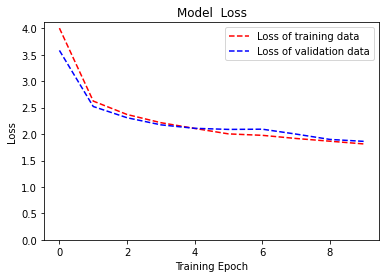

In [65]:
# for i in history.history:
#     print("history",i)
# plt.figure(figsize=(10, 8))
import csv
print(len(history.history['loss']))
result = csv.reader(open("/media/naveen/nav/mat_codes/nina_DB2_codes/olsson_DB2/CNN100X12/trainvsval.csv","r"))
train_data =[]
val_data=[]
for line in result:
#     data = line.split(",")
    train_data.append(float(line[0]))
    val_data.append(float(line[1]))
    

# for i in range(0,len(history.history['loss'])):
# #     print(history.history['loss'][i],history.history['val_loss'][i])
#     result.writelines(str(history.history['loss'][i])+","+str(history.history['val_loss'][i])+"\n")
plt.plot(train_data, 'r--', label='Loss of training data')
plt.plot(val_data, 'b--', label='Loss of validation data')
plt.title('Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()